# Assignement Introduction

We are not providing you with any code for this assignment, so you must code everything yourself. However, we are providing you with an example notebook on how to run an MCMC. Furthermore, we provide a noise-free and noisy reference model from which you must derive parameters. Lastly, we give you three noisy covariance matrices. We recommend running the MCMC not in a Jupyter Notebook but instead using an external Python script.


You can use any sampler you like to use for the following tasks. Also, you can use your own emulator. You must use the noisy reference model for the first three tasks. Check for each task, check that the posteriors and the $\chi^2$ distributions are as expected.



# Answers:

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
from numpy.linalg import inv
from cosmopower_NN import cosmopower_NN
import tensorflow as tf
import gc
from getdist import plots, MCSamples, parampriors
import getdist
import emcee
from sklearn.decomposition import PCA
import multiprocess as mp
import os 

In [2]:
cov=np.load('data_4_assignment3/covariance.npy')
cov_inv = inv(cov)

minimum=np.load('data_4_assignment3/minimum.npy')
maximum=np.load('data_4_assignment3/maximum.npy')

reference_model = np.load('data_4_assignment3/reference_model.npy')
reference_model_noisy = np.load('data_4_assignment3/reference_model_noise.npy')

cp_nn_model = cosmopower_NN(restore=True, restore_filename='data_4_assignment3/emulator_final')

cov_num_1500 = np.load('data_4_assignment3/cov_num_1500.npy')
cov_num_3000 = np.load('data_4_assignment3/cov_num_3000.npy')
cov_num_10000 = np.load('data_4_assignment3/cov_num_10000.npy')

inv_cov_num_1500, inv_cov_num_3000, inv_cov_num_10000 = inv(cov_num_1500), inv(cov_num_3000), inv(cov_num_10000)

### 1. Run an MCMC where you vary all four parameters you have trained on your emulator.

#### Functions:

In [5]:
total_steps = 3000 # total  number of steps each walker is doing
burning_steps = 1000 # how many buring steps you want to remove
nwalkers = 100 # Number of walkers that probe the parameter space

num_threads = 30 # number of cpu cores to use

#which paramters we want to vary
parameters = np.load('data_4_assignment2/parameters.npz')
param_names_varying = parameters.files #['omega_m', 'As'] # alternatively you can also just use parameters.files
ndim = len(param_names_varying)

# print(list(np.array(parameters[name])[55]))
reference_params = {}
for name in parameters.keys():
    reference_params[name] = np.array(parameters[name])[55] #list(np.array(parameters[name])[55])

In [6]:
param_names_varying

['omega_m', 'omega_b', 'As', 'w']

In [11]:
## a function that distributed start postions inside the trained parameters
def start_position_lh_and_step_size(seed):
    random.seed(seed)
    p0 = []
    for i in range(nwalkers):
        random_starts = []
        
        for name in param_names_varying:
            lower_edge = np.min(parameters[name])
            upper_edge = np.max(parameters[name])
            
            if name == 'omega_b':
                lower_edge = 0.035
                upper_edge = 0.055
            if name == 'omega_m':
                lower_edge = 0.3
                upper_edge = 0.38
            if name == 'As':
                lower_edge = 1.8e-9
                upper_edge = 2.3e-9
            if name == 'w':
                lower_edge = -2
                upper_edge = -1
            
            # if(lower_edge<0):
            #     lower_edge = lower_edge * 0.69
            # else:
            #     lower_edge = lower_edge * 1.11
            # if(upper_edge>0):
            #     upper_edge = upper_edge * 0.69
            # else:
            #     upper_edge = upper_edge * 1.11     
           
            # print(name)     
            # print(lower_edge, upper_edge)     
            random_starts.append(random.uniform(lower_edge,upper_edge))

        p0.append(random_starts)
        
    return np.array(p0)

In [12]:
## function that computes our priors. Here we only allow the walker to be inside the training range. You can also define Gaussian priors. 
def cal_logprior(para_dict):

    lnprior = 0
    #cosmological priors
    for name in param_names_varying:
        if(para_dict[name]>np.max(parameters[name])):
            lnprior = -np.inf
        if(para_dict[name]<np.min(parameters[name])):
            lnprior = -np.inf
    
    return lnprior

In [13]:
## Function that computes the likelihood
def calc_likelihood(para):
    
    params = {'omega_b':reference_params['omega_b'],'w':reference_params['w'], 'omega_m':reference_params['omega_m'], 'As':reference_params['As']}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    # print(params)

    pred_vector = cp_nn_model.predictions_np(params)[0]
    pred_vector = pred_vector*maximum+minimum 
    
    # print(pred_vector.shape,reference_model.shape,cov_inv.shape)
    
    delta = pred_vector - reference_model_noisy
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior
 

In [14]:
def plot_chi2_distributions(chi2_distributions_to_plot, save_name, labels, step):
    
    
    for i in range(len(chi2_distributions_to_plot)):
        
        if step == True:
            plt.hist(chi2_distributions_to_plot[i],bins=100, label=labels[i], histtype='step')
        else:
            plt.hist(chi2_distributions_to_plot[i],bins=100, label=labels[i])
    
    plt.legend(loc='best')
    plt.xlabel(r'$\chi^{2}$')
    
    plt.savefig('plots_4_assignment3/'+save_name+'.jpg',dpi=400, bbox_inches='tight')
    

In [15]:
def plot_getdist_corner(emcee_sample_chains, save_name, labels, filled):
    para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])
    param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

    parameters = np.load('data_4_assignment2/parameters.npz')
    parameters.keys()
    para_priors = {}
    para_priors_low = {}
    para_priors_up = {}
    for name in para_names:
        para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
        para_priors_low[name] = np.min(parameters[name])
        para_priors_up[name] = np.max(parameters[name])
        
    priors = parampriors.ParamBounds()
    
    getdist_emcee_samples = []
    for i in range(len(emcee_sample_chains)):
        getdist_emcee = MCSamples(samples=emcee_sample_chains[i],names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
        getdist_emcee_samples.append(getdist_emcee)
        
    colors = ['lightcoral', 'royalblue', 'orange', 'green']
    bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
    retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

    g = plots.get_subplot_plotter(width_inch=12)
    g.settings.axis_marker_lw = 1.0
    g.settings.axis_marker_ls = '-'
    g.settings.title_limit_labels = False
    g.settings.axis_marker_color = 'k'
    g.settings.legend_colored_text = True
    g.settings.figure_legend_frame = False
    g.settings.linewidth = 2.0
    g.settings.linewidth_contour = 3.0
    g.settings.legend_fontsize = 22
    g.settings.axes_fontsize = 17
    g.settings.axes_labelsize = 22
    g.settings.axis_tick_x_rotation = 45
    g.settings.axis_tick_max_labels = 6
    g.settings.solid_colors = retro
    
    g.triangle_plot(
    roots=getdist_emcee_samples,
    filled=filled,
    legend_loc='upper right',
    legend_labels = labels,
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
    )
    
    plt.savefig('plots_4_assignment3/'+save_name+'.jpg',dpi=400, bbox_inches='tight')

In [9]:
print(emcee.__version__)

3.1.4


#### Running MCMC for Task 1:

In [15]:
p0 = start_position_lh_and_step_size(np.random.randint(1e6))

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_emcee = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee',samples_emcee)
log_prob_samples = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee',log_prob_samples)

100%|██████████| 2000/2000 [18:14<00:00,  1.83it/s]


#### Plotting:

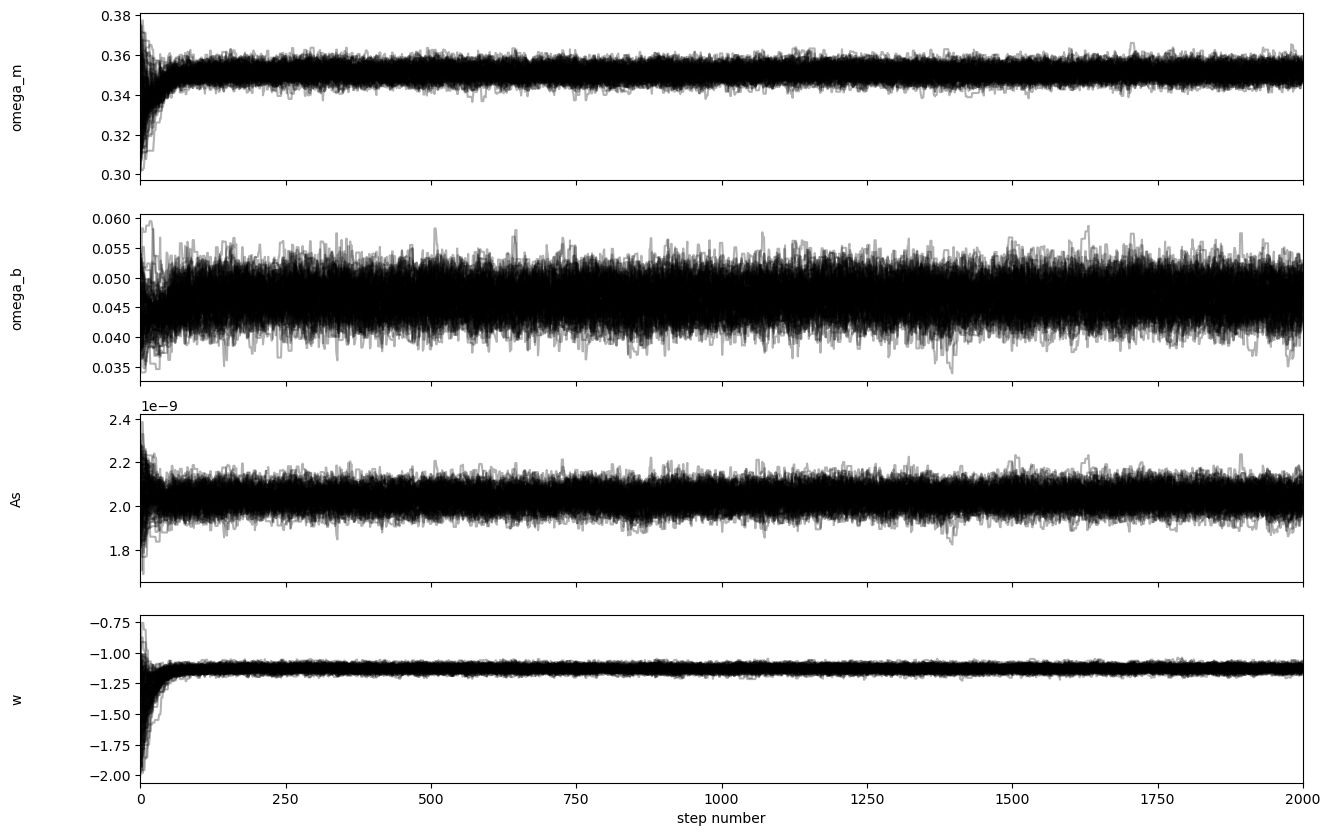

In [16]:
fig, axes = plt.subplots(ndim, figsize=(15, 10), sharex=True)
samples = sampler.get_chain()
labels = param_names_varying #["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

plt.savefig('plots_4_assignment3/MCMC_chain_task1.jpg',dpi=400, bbox_inches='tight')

Removed no burn in


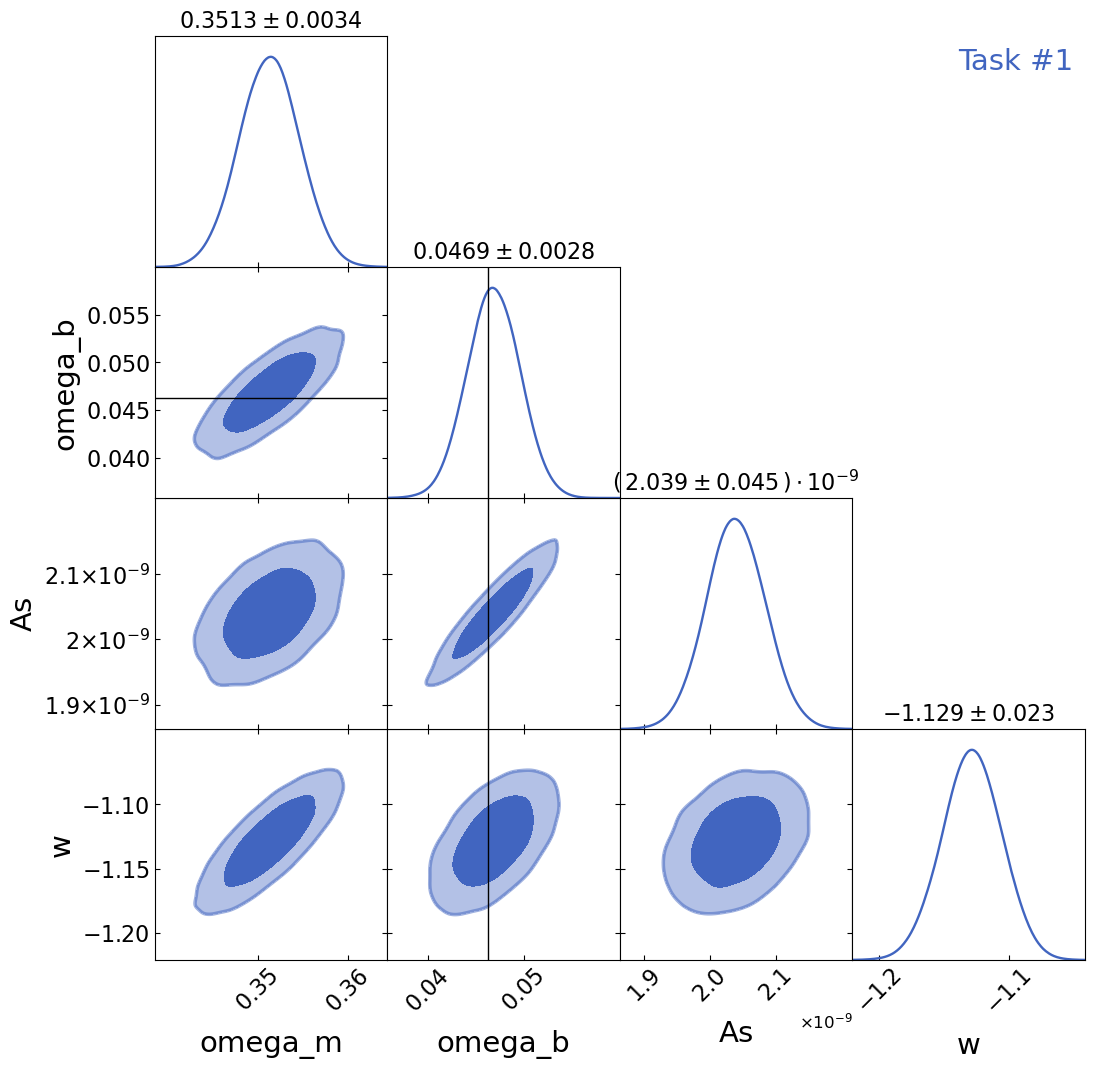

In [12]:
samples_emcee = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee.npy')

plot_getdist_corner([samples_emcee], 'MCMC_corner_task1', ['Task #1'], True)

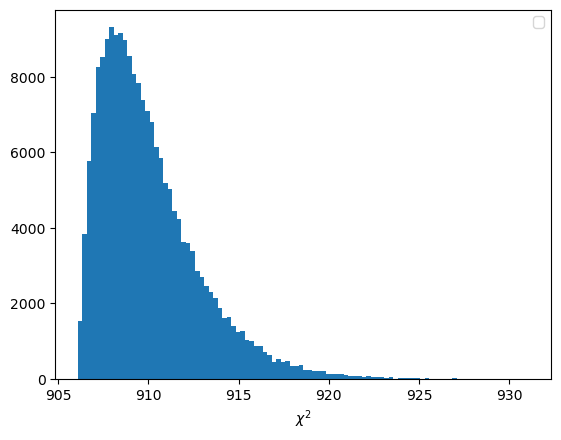

In [29]:
emcee_chi2= -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee.npy')
    
plot_chi2_distributions([emcee_chi2], 'chi2_distribution_task1', [''], False)

#### Comments on results for this Task:

I noticed that regardless of how many walkers or steps I ran my MCMC for, there were always some walkers getting stuck in what is presumed to be a local minima. This obviously, threw off the results and constraints obtained for each of the four parameters. To fix this, in the 'start_position_lh_and_step_size' function which is used to get the random starting positions for all the walkers, I hardcoded in a lower- and upper-edge value for all the parameters. I determined these values based on previous interations of running the MCMC and seeing on the corner plot the range of values for which the walkers converged.

We see from the chi-squared distribution that it is not perfectly peaked at a chi2 value of 900 which would expect it to. The main reason for this is due to the fact that MCMC's in practice, jump around as they move towards the global minima. At this global minima we expect the chi2 value to be minimized. Due to the stochastic nature of how MCMC's reach the global minima we would see that reflected in the fact that the chi2 distribution doesn't peak perfectly at 900, but it is very close which does reinforce that the constraints we do get are valid and good.

---------------------

### 2. Use the provided numerical covariance matrices with [1.5k,3k,10k] data vectors as in assignment one. Run an MCMC for all of them with and without Hartlap correction, and compare with your results. Link your results to assignment one.

#### Functions:

In [13]:
## Function that computes the likelihood
def calc_likelihood_hartlap(para, inv_cov, realizations, dimensions):
    
    params = {'omega_b':reference_params['omega_b'],'w':reference_params['w'], 'omega_m':reference_params['omega_m'], 'As':reference_params['As']}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    # print(params)
    
    n_r = realizations # number of realisations used  # this is the length of the numerical covariance matrix used or is it 900?
    n_d = dimensions # dimension of the model 
    h = (n_r-1)/(n_r-n_d-2)
    cov_inv_hartlap = inv_cov/h

    pred_vector = cp_nn_model.predictions_np(params)[0]
    pred_vector = pred_vector*maximum+minimum 
    

    # print(pred_vector.shape,reference_model.shape,cov_inv.shape)
    
    delta = pred_vector - reference_model_noisy
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv_hartlap,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior

def calc_likelihood_nohartlap(para, inv_cov):
    
    params = {'omega_b':reference_params['omega_b'],'w':reference_params['w'], 'omega_m':reference_params['omega_m'], 'As':reference_params['As']}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]


    pred_vector = cp_nn_model.predictions_np(params)[0]
    pred_vector = pred_vector*maximum+minimum 
    

    # print(pred_vector.shape,reference_model.shape,cov_inv.shape)
    
    delta = pred_vector - reference_model_noisy
    likelihood = -0.5*np.matmul(delta,np.matmul(inv_cov,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior

In [14]:
def run_and_save_hartlap_nohartlap_MCMC(inv_cov_num, save_names, realizations, dimensions):
    
    # MCMC but WE DO apply the Hartlap factor
    sampler_hartlap = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_hartlap, args=[inv_cov_num, realizations, dimensions])
    sampler_hartlap.run_mcmc(p0, total_steps, progress=True)

    samples_emcee_hartlap = sampler_hartlap.get_chain(discard=burning_steps,flat=True)
    np.save('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_'+save_names[0], samples_emcee_hartlap)
    log_prob_samples_hartlap = sampler_hartlap.get_log_prob(discard=burning_steps, flat=True)
    np.save('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_'+save_names[0], log_prob_samples_hartlap)
    
    # MCMC but NOT applying the Hartlap factor
    sampler_nohartlap = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_nohartlap, args=[inv_cov_num])
    sampler_nohartlap.run_mcmc(p0, total_steps, progress=True)

    samples_emcee_nohartlap = sampler_nohartlap.get_chain(discard=burning_steps,flat=True)
    np.save('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_'+save_names[1], samples_emcee_nohartlap)
    log_prob_samples_nohartlap = sampler_nohartlap.get_log_prob(discard=burning_steps, flat=True)
    np.save('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_'+save_names[1], log_prob_samples_nohartlap)

In [15]:
def plot_and_save_mcmc_chain(mcmc_sampler, save_name, title):
    fig, axes = plt.subplots(ndim, figsize=(15, 10), sharex=True)
    samples = mcmc_sampler.get_chain()
    labels = param_names_varying #["m", "b", "log(f)"]
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")
    plt.title(title)

    plt.savefig('plots_4_assignment3/MCMC_chain_'+save_name+'.jpg',dpi=400, bbox_inches='tight')

#### 1.5k Numerical Covariance Matrix

##### Run MCMC:

In [19]:
p0 = start_position_lh_and_step_size(0)
run_and_save_hartlap_nohartlap_MCMC(inv_cov_num_1500, ['numcov1500_hartlap', 'numcov1500_nohartlap'], 1500, 900)

100%|██████████| 3000/3000 [33:27<00:00,  1.49it/s]  


##### Plotting:

Removed no burn in
Removed no burn in


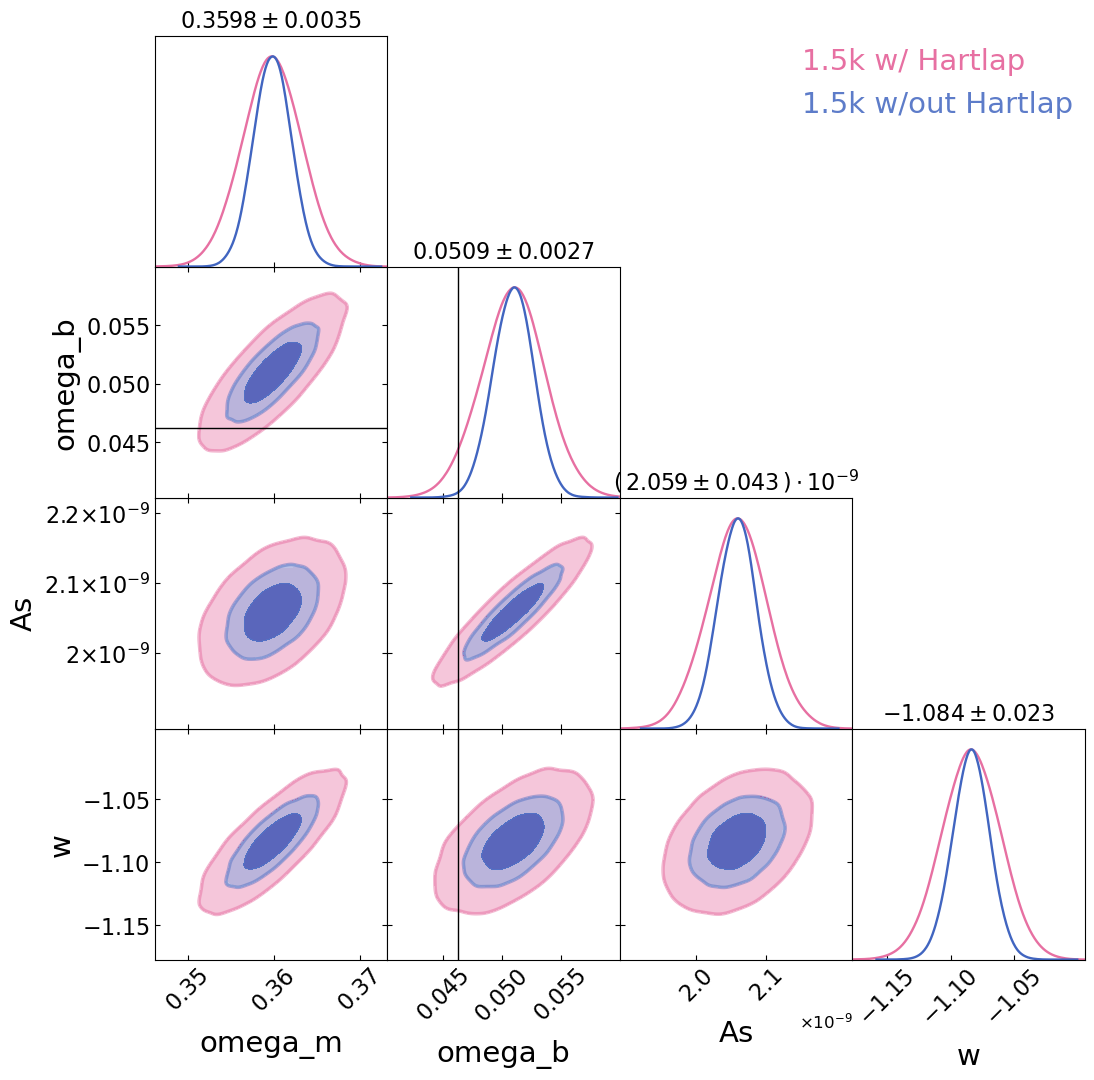

In [17]:
samples_emcee_hartlap = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_hartlap.npy')
samples_emcee_nohartlap = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_nohartlap.npy')
chains = [samples_emcee_hartlap, samples_emcee_nohartlap]

plot_getdist_corner(chains, 'MCMC_corner_task2_1500covnum', ['1.5k w/ Hartlap','1.5k w/out Hartlap'], True)

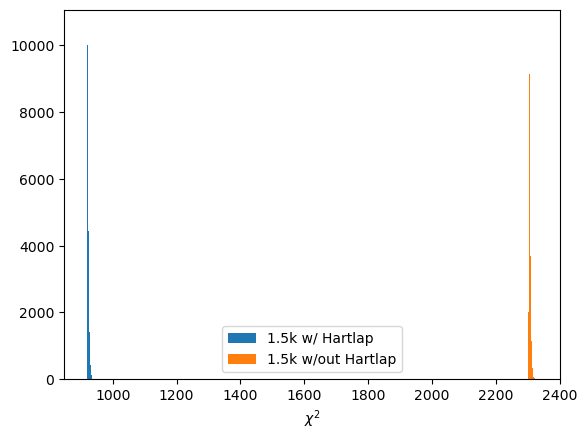

In [36]:
emcee_chi2_hartlap = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_hartlap.npy')
emcee_chi2_nohartlap = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_nohartlap.npy')

plot_chi2_distributions([emcee_chi2_hartlap, emcee_chi2_nohartlap], 'chi2_distribution_task2_1500numcov', ['1.5k w/ Hartlap', '1.5k w/out Hartlap'], False)

##### Comments on Results:

From the corner plot, we notice that when the Hartlap factor is applied to the results when running the MCMC using the 1.5k data vector numerical covariance matrix that the constraints obtained by the MCMC are not as tight/constrained as when we do not apply the Hartlap factor. At face value, one might then (incorrectly) interpret that not applying the Hartlap factor is better, this is not true. The proof is shown when plotting the chi-squared distributon. We expect the chi2 distribution to peak ~900 but as we see, when we do not apply the Hartlap factor the chi2 distribution is shifted significantly to the right. This tell us that the MCMC run when not applying the Hartlap factor is not converging to the correct parameter constraints. Essentially, when we apply the Hartlap factor, it is correcting the posterioro distributions to be better centred on the correct parameter constraint value (proof of this is shown later in task 3). In doing so, the posterior distribution itself does get large.

#### 3K Numerical Covariance Matrix

##### Run MCMC:

In [22]:
p0 = start_position_lh_and_step_size(0)
run_and_save_hartlap_nohartlap_MCMC(inv_cov_num_3000, ['numcov3000_hartlap', 'numcov3000_nohartlap'], 3000, 900)

100%|██████████| 3000/3000 [4:15:48<00:00,  5.12s/it]      


##### Plotting:

Removed no burn in
Removed no burn in


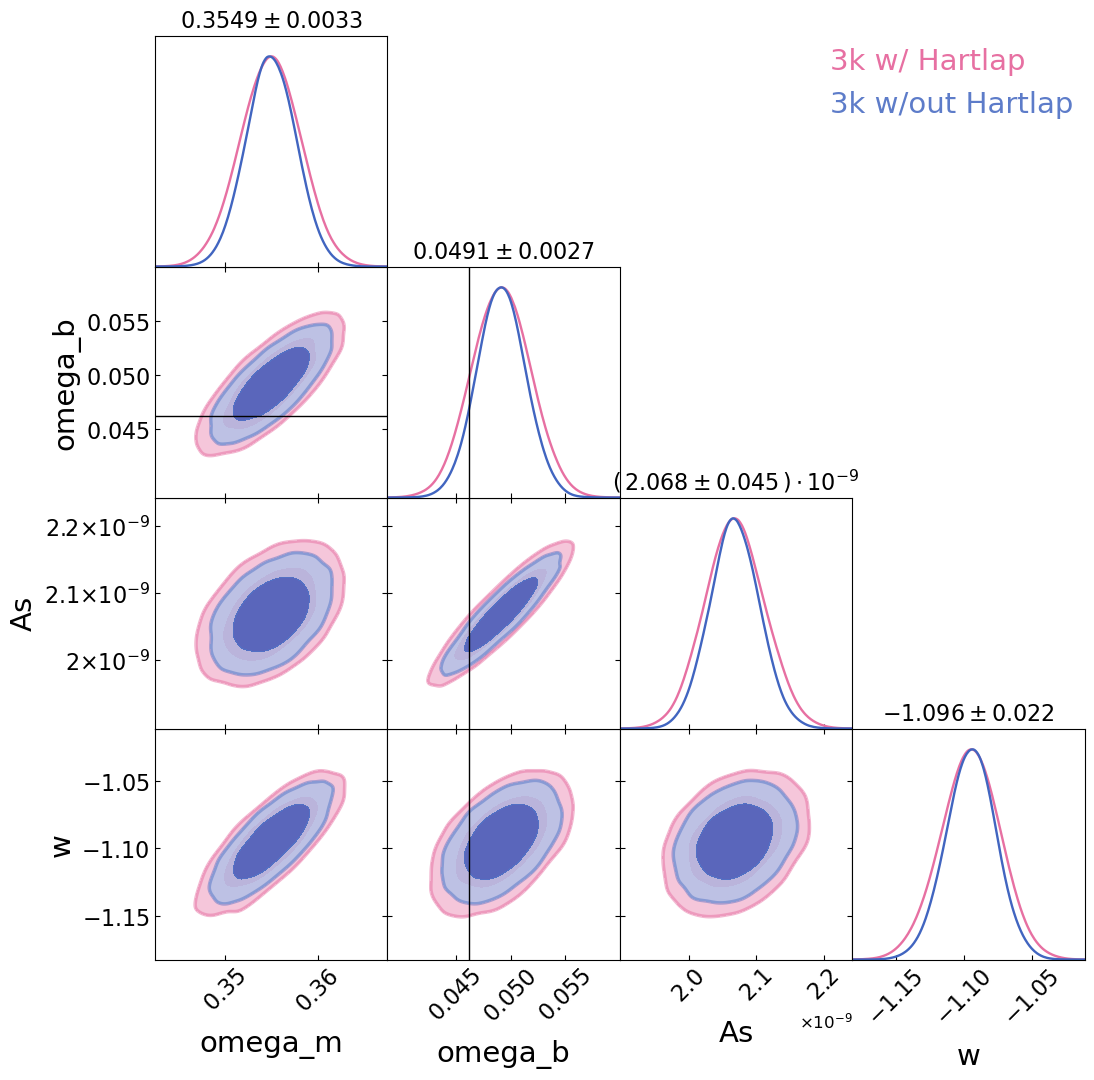

In [23]:
samples_emcee_hartlap = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov3000_hartlap.npy')
samples_emcee_nohartlap = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov3000_nohartlap.npy')
chains = [samples_emcee_hartlap, samples_emcee_nohartlap]

plot_getdist_corner(chains, 'MCMC_corner_task2_3000covnum', ['3k w/ Hartlap','3k w/out Hartlap'])

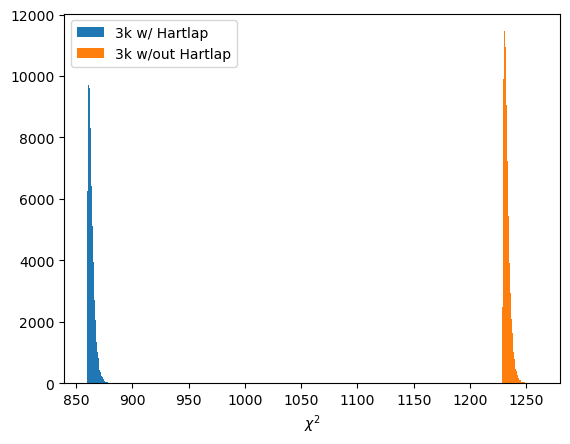

In [24]:
emcee_chi2_hartlap = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov3000_hartlap.npy')
emcee_chi2_nohartlap = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov3000_nohartlap.npy')

plot_chi2_distributions([emcee_chi2_hartlap, emcee_chi2_nohartlap], 'chi2_distribution_task2_3000numcov', ['3k w/ Hartlap', '3k w/out Hartlap'])

##### Comments on Results:

Similar to the comments discussed for the 1.5k num cov results, we see the same sort of trend. The difference now is that we are using a numerical matrix made up of 3000 data vectors. As we saw in assignment 1, the more data vectors we take and use in our numerical covariance matrix the closer the results look to if we used the analytical matrix. In this case however, the more data vectors we use the posterior distribution for the not Hartlap factor corrected MCMC is wider and becomes closer to the distribution of the Hartlap corrected. The subsequent chi2 distribution for the not Hartlap corrected MCMC still is significantly shifted to higher values but as compared to the 1.5k num cov matrix, the chi2 distribution is closer to the Hartlap corrected one.

#### 10K Numerical Covariance Matrix

##### Run MCMC:

In [25]:
p0 = start_position_lh_and_step_size(0)
run_and_save_hartlap_nohartlap_MCMC(inv_cov_num_10000, ['numcov10000_hartlap', 'numcov10000_nohartlap'], 10000, 900)

100%|██████████| 3000/3000 [28:08<00:00,  1.78it/s]


##### Plotting:

Removed no burn in
Removed no burn in


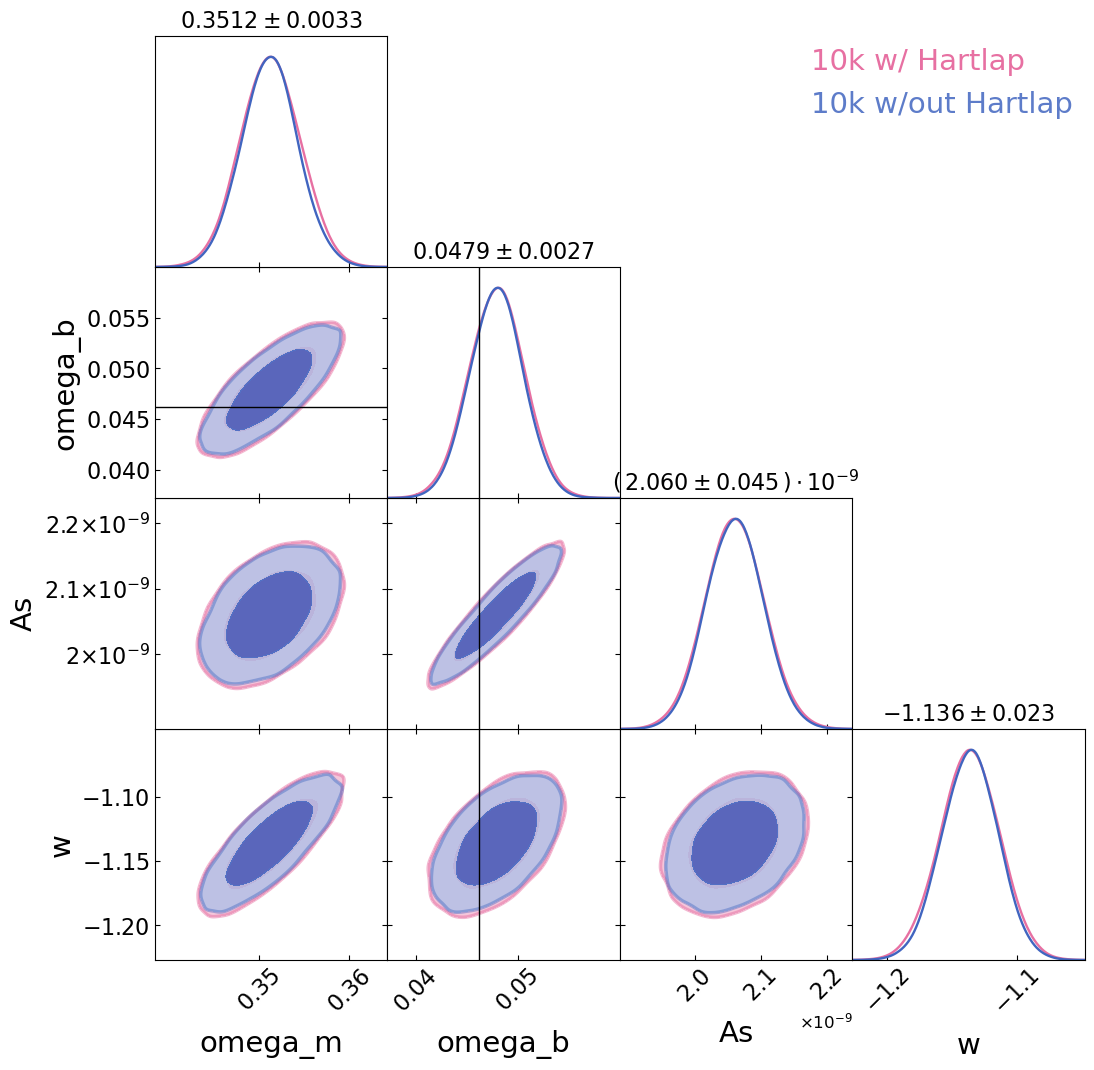

In [26]:
samples_emcee_hartlap = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov10000_hartlap.npy')
samples_emcee_nohartlap = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov10000_nohartlap.npy')
chains = [samples_emcee_hartlap, samples_emcee_nohartlap]

plot_getdist_corner(chains, 'MCMC_corner_task2_10000covnum', ['10k w/ Hartlap','10k w/out Hartlap'])

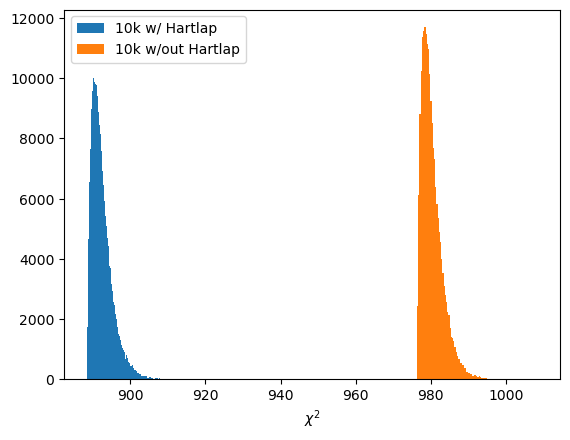

In [27]:
emcee_chi2_hartlap = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov10000_hartlap.npy')
emcee_chi2_nohartlap = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov10000_nohartlap.npy')

plot_chi2_distributions([emcee_chi2_hartlap, emcee_chi2_nohartlap], 'chi2_distribution_task2_10000numcov', ['10k w/ Hartlap', '10k w/out Hartlap'])

##### Comments on Results:

Finally, in this subtask we use the 10k numerical covariance matrix. From the corner plot we see that both the Hartlap corrected and not Hartlap corrected posterior distributions from the MCMC look almost identical presenting similar paramter constraints. This makes sense as from assignment 1 we saw that, the more realizations (so data vectors) we take for our numerical covariance matrix the closer the chi2 distributions mean and variance gets to what is expected. In this case we expect a mean very close to 900.

It is worth noting that in plot chi2 plot presented above even when we Hartlap correct we see that the peak/mean of the chi2 distribution is now less than 900. This ultimately goes back to the argument made in the discussion for task 1 concernign the stochastisicty of running an MCMC and how the walkers make large to small jumps as they converge to the minima. They never will exact land at the minima so we will never get a perfect chi2 distribution centered at the expected mean of 900.

#### Hartlap

##### Plotting:

Removed no burn in
Removed no burn in
Removed no burn in


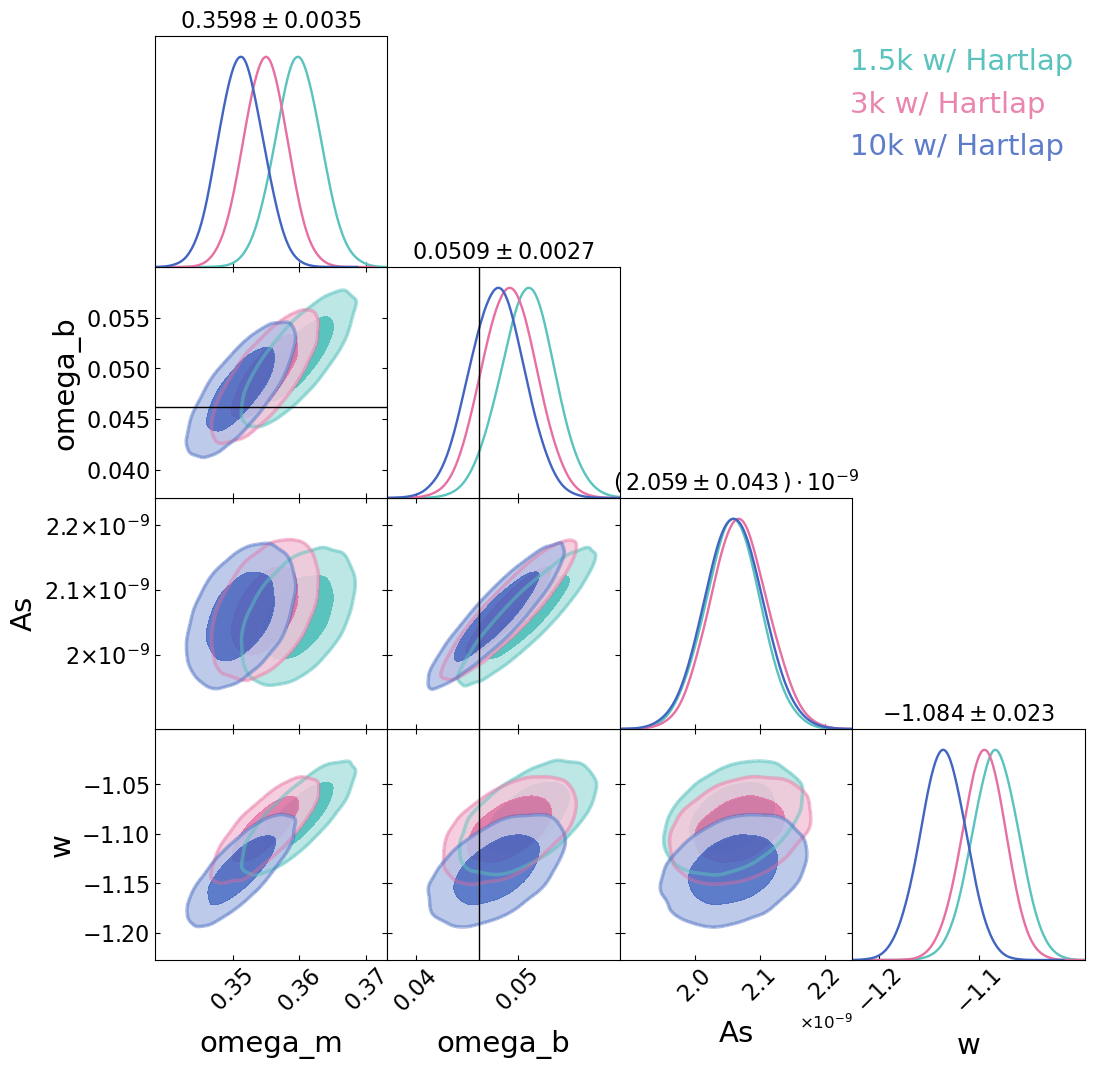

In [21]:
samples_emcee_hartlap_1 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_hartlap.npy')
samples_emcee_hartlap_2 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov3000_hartlap.npy')
samples_emceee_hartlap_3 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov10000_hartlap.npy')

chains = [samples_emcee_hartlap_1, samples_emcee_hartlap_2, samples_emceee_hartlap_3]

plot_getdist_corner(chains, 'MCMC_corner_task2_hartlap_together', ['1.5k w/ Hartlap', '3k w/ Hartlap', '10k w/ Hartlap'], True)

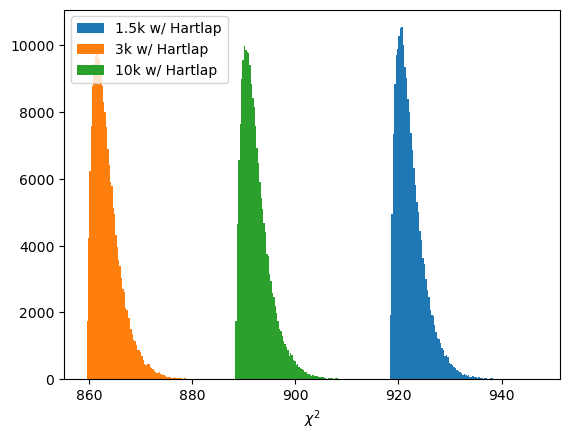

In [23]:
emcee_chi2_hartlap1 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_hartlap.npy')
emcee_chi2_hartlap2 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov3000_hartlap.npy')
emcee_chi2_hartlap3 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov10000_hartlap.npy')

plot_chi2_distributions([emcee_chi2_hartlap1, emcee_chi2_hartlap2, emcee_chi2_hartlap3], 'chi2_distribution_task2_hartlap_together', ['1.5k w/ Hartlap', '3k w/ Hartlap', '10k w/ Hartlap'], False)

#### No Hartlap

##### Plotting:

Removed no burn in
Removed no burn in
Removed no burn in


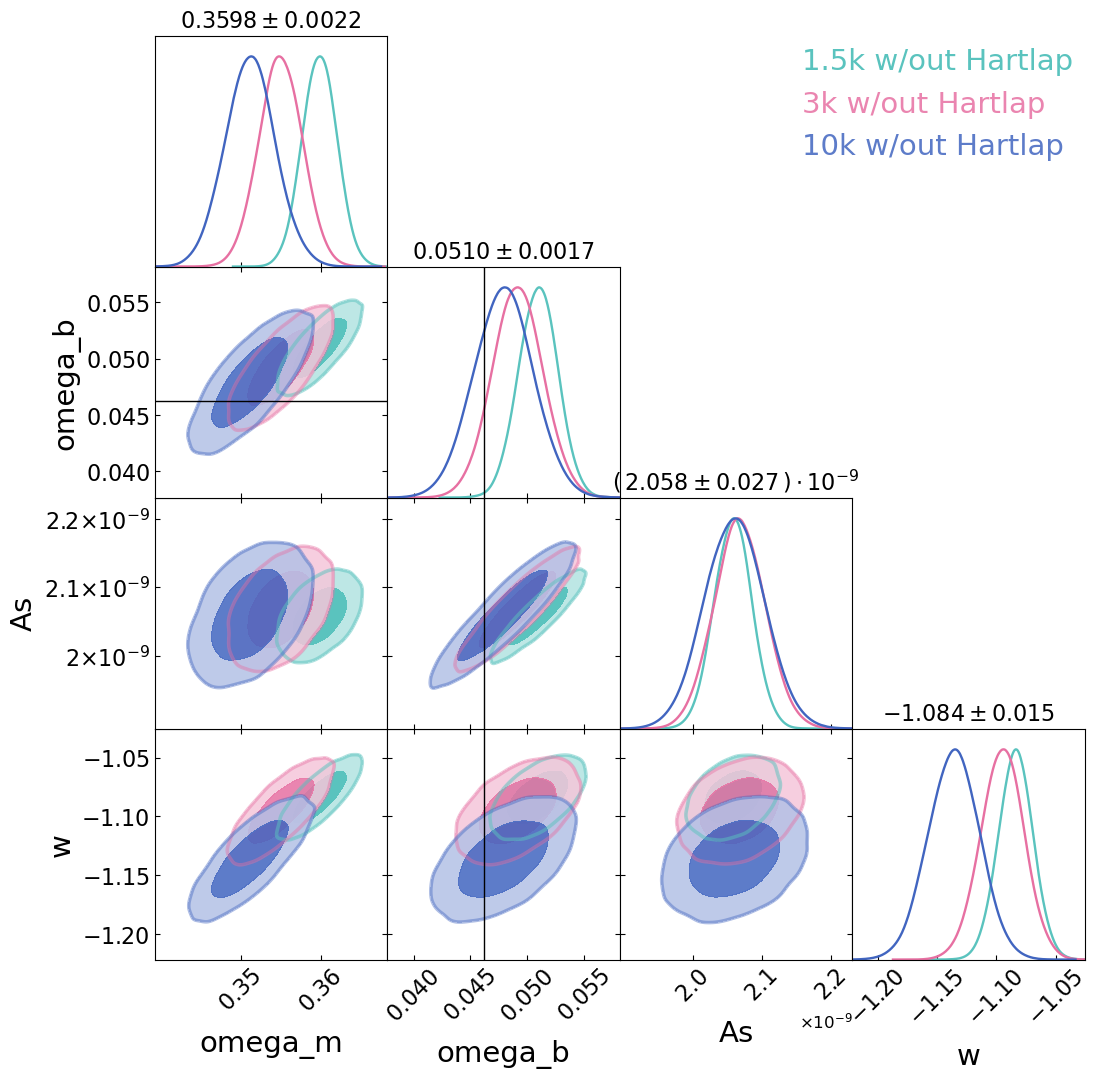

In [24]:
samples_emcee_nohartlap_1 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_nohartlap.npy')
samples_emcee_nohartlap_2 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov3000_nohartlap.npy')
samples_emceee_nohartlap_3 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov10000_nohartlap.npy')

chains = [samples_emcee_nohartlap_1, samples_emcee_nohartlap_2, samples_emceee_nohartlap_3]

plot_getdist_corner(chains, 'MCMC_corner_task2_nohartlap_together', ['1.5k w/out Hartlap', '3k w/out Hartlap', '10k w/out Hartlap'], True)

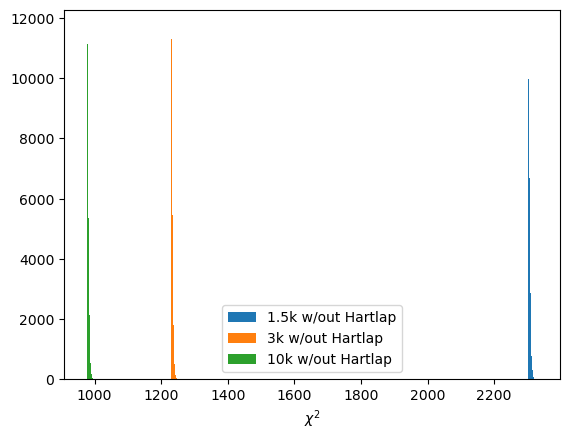

In [25]:
emcee_chi2_nohartlap1 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_nohartlap.npy')
emcee_chi2_nohartlap2 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov3000_nohartlap.npy')
emcee_chi2_nohartlap3 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov10000_nohartlap.npy')

plot_chi2_distributions([emcee_chi2_nohartlap1, emcee_chi2_nohartlap2, emcee_chi2_nohartlap3], 'chi2_distribution_task2_nohartlap_together', ['1.5k w/out Hartlap', '3k w/out Hartlap', '10k w/out Hartlap'], False)

#### Comments on Hartlap and No Hartlap:

In the previous two sections, I plot the Hartlap corrected results together and the not Hartlap corrected results together. What we see in the corner plots is the following:
- For both, the posterior distribution shifts as we increase the number of data vectors using in the numerical covariance matrix. This shift is an indication of the distribution getting closer to the actual best parameter constraint.
- We make note of the shape of the distributions. The not Hartlap corrected distributions start off smaller but as we use a num cov matrix of greater data vectors the distribution widens. This is not the case with the already Hartlap corrrected MCMC. All the distributions are, as far as the eye can see, very similar.
- We see once again that as we incerase the number of data vectors used in the num covmat, the chi2 distribution gets closer to the expected peak at ~900
- In the case of the Hartlap factor corrected MCMC's, their chi2 distribution are all much closer to 900 to begin with than the not Hartlap factor corrected. This is analogous to the resutls presented earlier and in assignment 1.


### 3. Next, we consider PCA data compression. Run an MCMC for several numbers of PCA elements. Link your results to assignment two.

##### Functions:

In [17]:
## Function that computes the likelihood
def calc_likelihood_PCA(para, cov_inv_pca, N_pca, pca):
    
    params = {'omega_b':reference_params['omega_b'],'w':reference_params['w'], 'omega_m':reference_params['omega_m'], 'As':reference_params['As']}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    pred_vector = cp_nn_model.predictions_np(params)[0]
    pred_vector_transformed = pca.transform([pred_vector*maximum+minimum])[0]
    
    reference_model_noisy_transformed = pca.transform([reference_model_noisy])[0]
       
    # print(pred_vector.shape,reference_model.shape,cov_inv_pca.shape)
    
    delta = pred_vector_transformed - reference_model_noisy_transformed
    
    
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv_pca,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior  

In [18]:
## Function that computes the likelihood
def calc_likelihood_PCA_hartlap(para, cov_inv_pca, N_pca, pca, realizations, dimensions):
    
    params = {'omega_b':reference_params['omega_b'],'w':reference_params['w'], 'omega_m':reference_params['omega_m'], 'As':reference_params['As']}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    pred_vector = cp_nn_model.predictions_np(params)[0]
    pred_vector_transformed = pca.transform([pred_vector*maximum+minimum])[0]
    
    reference_model_noisy_transformed = pca.transform([reference_model_noisy])[0]
       
    # print(pred_vector.shape,reference_model.shape,cov_inv_pca.shape)
    
    delta = pred_vector_transformed - reference_model_noisy_transformed
    
    n_r = realizations # number of realisations used  # this is the length of the numerical covariance matrix used or is it 900?
    n_d = dimensions # dimension of the model 
    h = (n_r-1)/(n_r-n_d-2)
    cov_inv_pca_hartlap = cov_inv_pca/h
    
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv_pca_hartlap,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior


####    3.a. Use the analytical covariance matrix.

In [29]:
models = np.load('data_4_assignment2/models.npy')
mean = np.mean(models,axis=0) # for numerical stability you should subtract the mean of each element

para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])

In [31]:
for N_pca in [100,300,600,900]:#tqdm(np.arange(1,900)):
    
    pca = PCA(n_components=N_pca,svd_solver='full')
    models_pca = pca.fit(models-mean) # Perform the PCA fitting. Now you can use pca for the transformation
    
    # Rotating the covariance matrix
    rotation_matrix = pca.components_.T
    cov_pca = rotation_matrix.T @ cov @ rotation_matrix 
    
    inv_cov_pca = inv(cov_pca) # select the first N_pca elements

    
    sampler_pca = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_PCA, args=[inv_cov_pca, N_pca, pca])
    sampler_pca.run_mcmc(p0, total_steps, progress=True)
    
    samples_emcee_pca = sampler_pca.get_chain(discard=burning_steps,flat=True)
    np.save('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_pca'+str(N_pca), samples_emcee_pca)
    log_prob_samples_pca = sampler_pca.get_log_prob(discard=burning_steps, flat=True)
    np.save('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_pca'+str(N_pca), log_prob_samples_pca)
    

100%|██████████| 3000/3000 [32:17<00:00,  1.55it/s] 


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


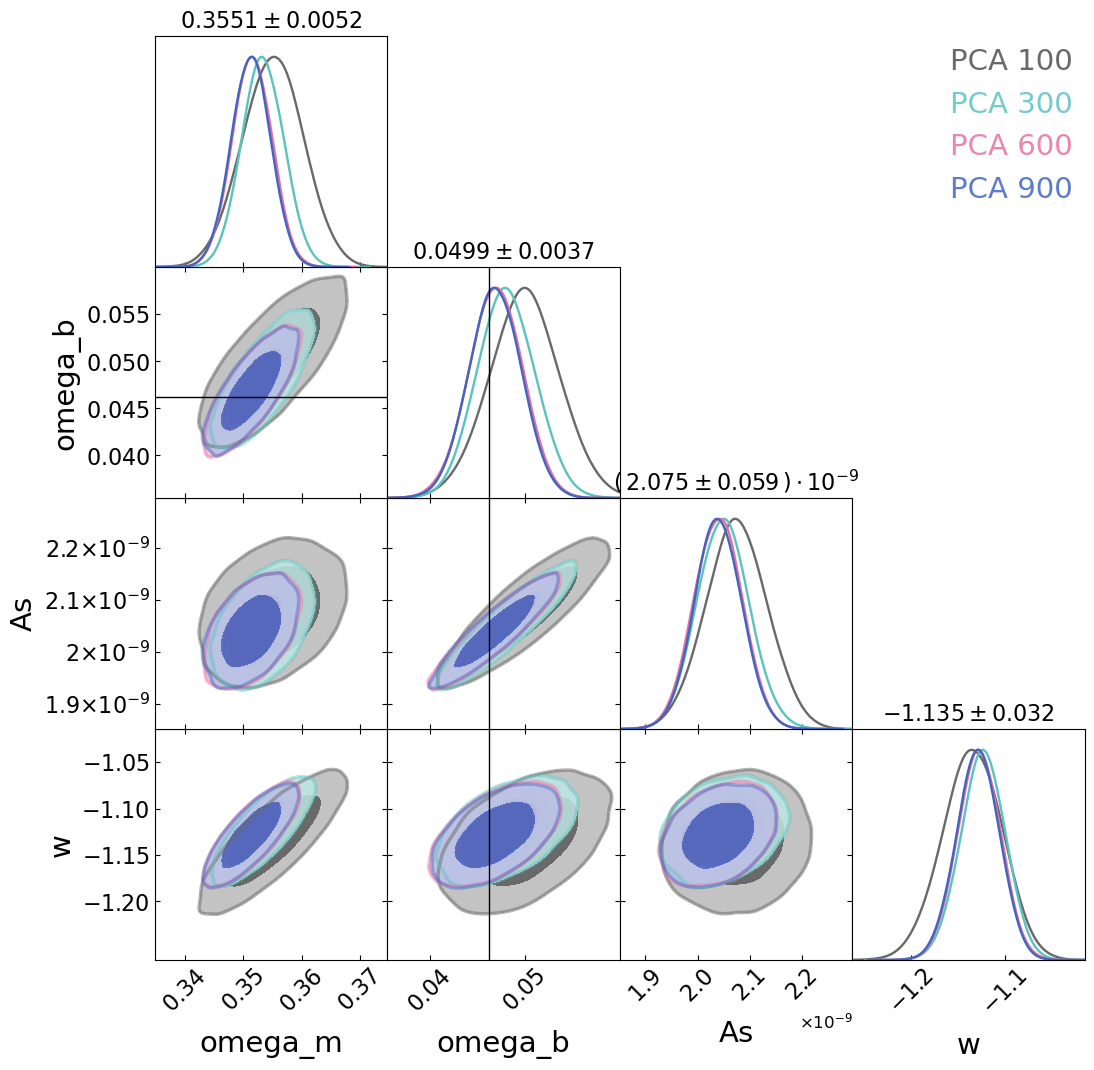

In [32]:
samples_emcee_pca100 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_pca100.npy')
samples_emcee_pca300 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_pca300.npy')
samples_emcee_pca600 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_pca600.npy')
samples_emcee_pca900 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_pca900.npy')
chains = [samples_emcee_pca100, samples_emcee_pca300, samples_emcee_pca600, samples_emcee_pca900]

plot_getdist_corner(chains, 'MCMC_corner_task3a_pca', ['PCA 100','PCA 300', 'PCA 600', 'PCA 900' ])

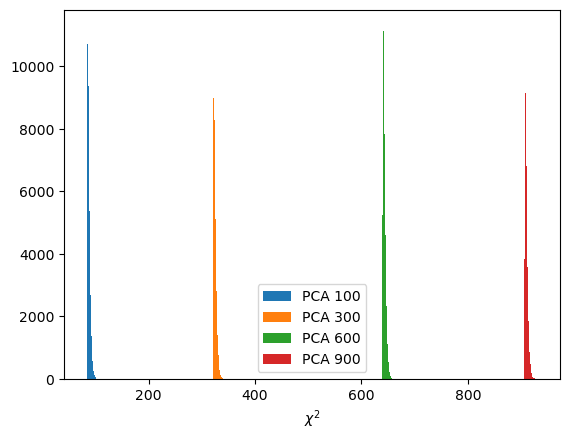

In [33]:
emcee_chi2_pca100 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_pca100.npy')
emcee_chi2_pca300 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_pca300.npy')
emcee_chi2_pca600 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_pca600.npy')
emcee_chi2_pca900 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_pca900.npy')


plot_chi2_distributions([emcee_chi2_pca100, emcee_chi2_pca300, emcee_chi2_pca600, emcee_chi2_pca900], 'chi2_distribution_task3a_pca', ['PCA 100', 'PCA 300', 'PCA 600', 'PCA 900'])

##### Comments on Results:

In Assignment 2, specifically in the last task, we determined how many PCA elements it took to reach 10% and 1% constrianing power as compared to the max constraint on the parameters of interest. We found that it took signifincatly less PCA elements than total degrees of freedom to reach 10% and 1% constraining power. We see proof of that once more looking at the corner plot of the posterior distributions. We see that at just 600 PCA elements we almost acivhede exactly the same constraining power for the 4 varying paramters in the case of using all the elements (i.e., 900 PCA). The distribution of PCA 300 is not entirely off from PCA 600 and PCA 900, and so, around 400-600 PCA elements would be sufficient to get the same constraining power. Ultimately, this shows that using PCA, we can speed up our analysis while obtaining very good parameter constraints.

The chi2 distributions shows that the mean of the distribution is very close to being centred at the number of degrees of freedom. In other words, if we take 300 PCA elements, we expect the chi2 ditribution to peak at 300, and PCA 600 to peak at 600 etc.

####    3.b. Use the 1.5k covariance matrix. Do you observe the same trend as in 3.a?

In [34]:
for N_pca in [100,300,600,900]:#tqdm(np.arange(1,900)):
    
    pca = PCA(n_components=N_pca,svd_solver='full')
    models_pca = pca.fit(models-mean) # Perform the PCA fitting. Now you can use pca for the transformation
    
    # Rotating the covariance matrix
    rotation_matrix = pca.components_.T
    cov_pca = rotation_matrix.T @ cov_num_1500 @ rotation_matrix  # using the numerical cov matrix of 1500 data vectors
    
    inv_cov_pca = inv(cov_pca) # select the first N_pca elements

    sampler_1500numcov_pca = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_PCA_hartlap, args=[inv_cov_pca, N_pca, pca, 1500, 900])
    sampler_1500numcov_pca.run_mcmc(p0, total_steps, progress=True)
    
    samples_emcee_1500numcov_pca = sampler_1500numcov_pca.get_chain(discard=burning_steps,flat=True)
    np.save('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_pca'+str(N_pca), samples_emcee_1500numcov_pca)
    log_prob_samples_1500numcov_pca = sampler_1500numcov_pca.get_log_prob(discard=burning_steps, flat=True)
    np.save('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_pca'+str(N_pca), log_prob_samples_1500numcov_pca)
    

100%|██████████| 3000/3000 [47:47<00:00,  1.05it/s] 


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


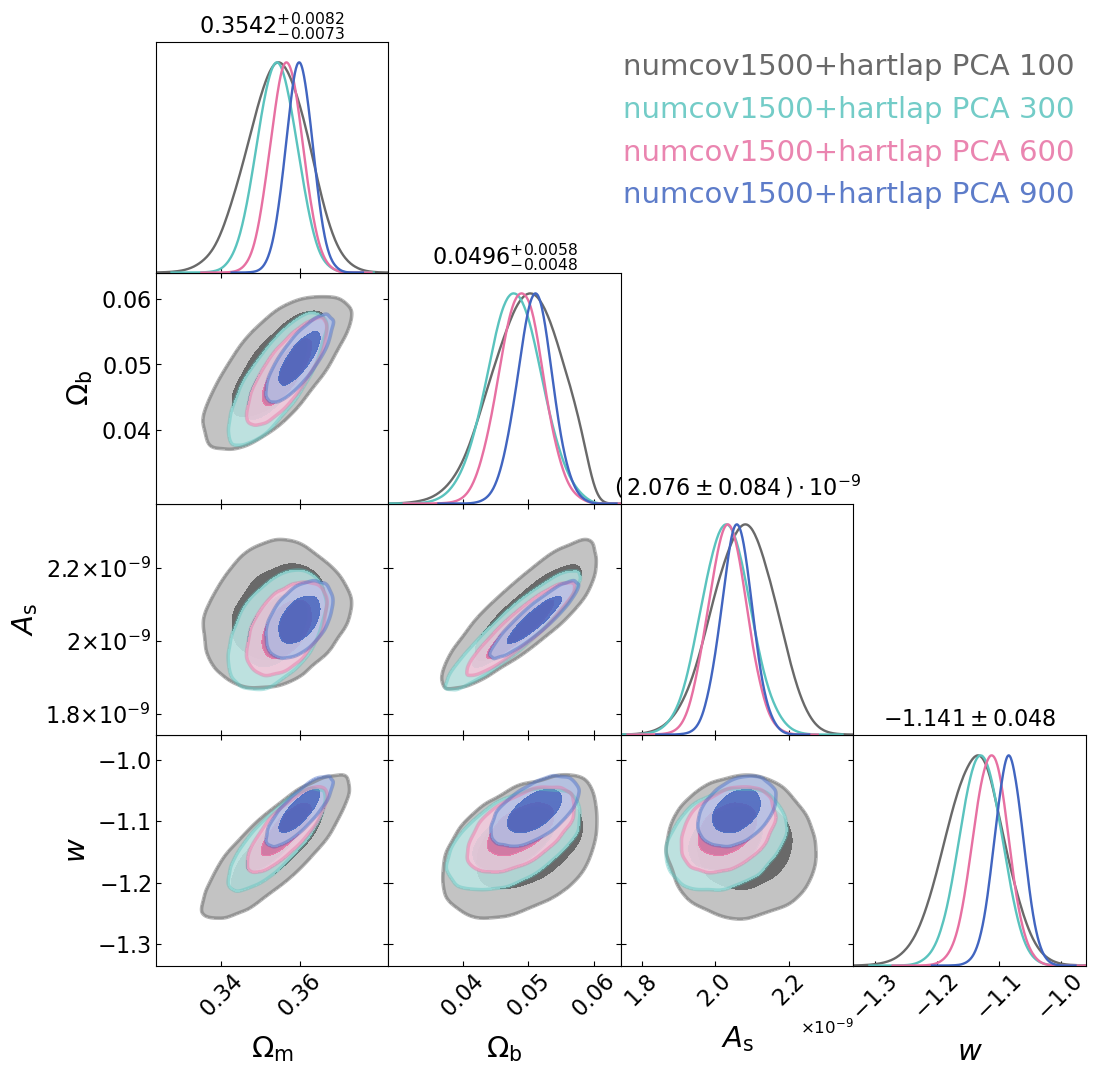

In [7]:
samples_emcee_cov1500_pca100 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_pca100.npy')
samples_emcee_cov1500_pca300 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_pca300.npy')
samples_emcee_cov1500_pca600 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_pca600.npy')
samples_emcee_cov1500_pca900 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_pca900.npy')
chains = [samples_emcee_cov1500_pca100, samples_emcee_cov1500_pca300, samples_emcee_cov1500_pca600, samples_emcee_cov1500_pca900]

plot_getdist_corner(chains, 'MCMC_corner_task3b_pca_with_numcov1500_withHartlap', ['numcov1500+hartlap PCA 100','numcov1500+hartlap PCA 300', 'numcov1500+hartlap PCA 600', 'numcov1500+hartlap PCA 900' ], True)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


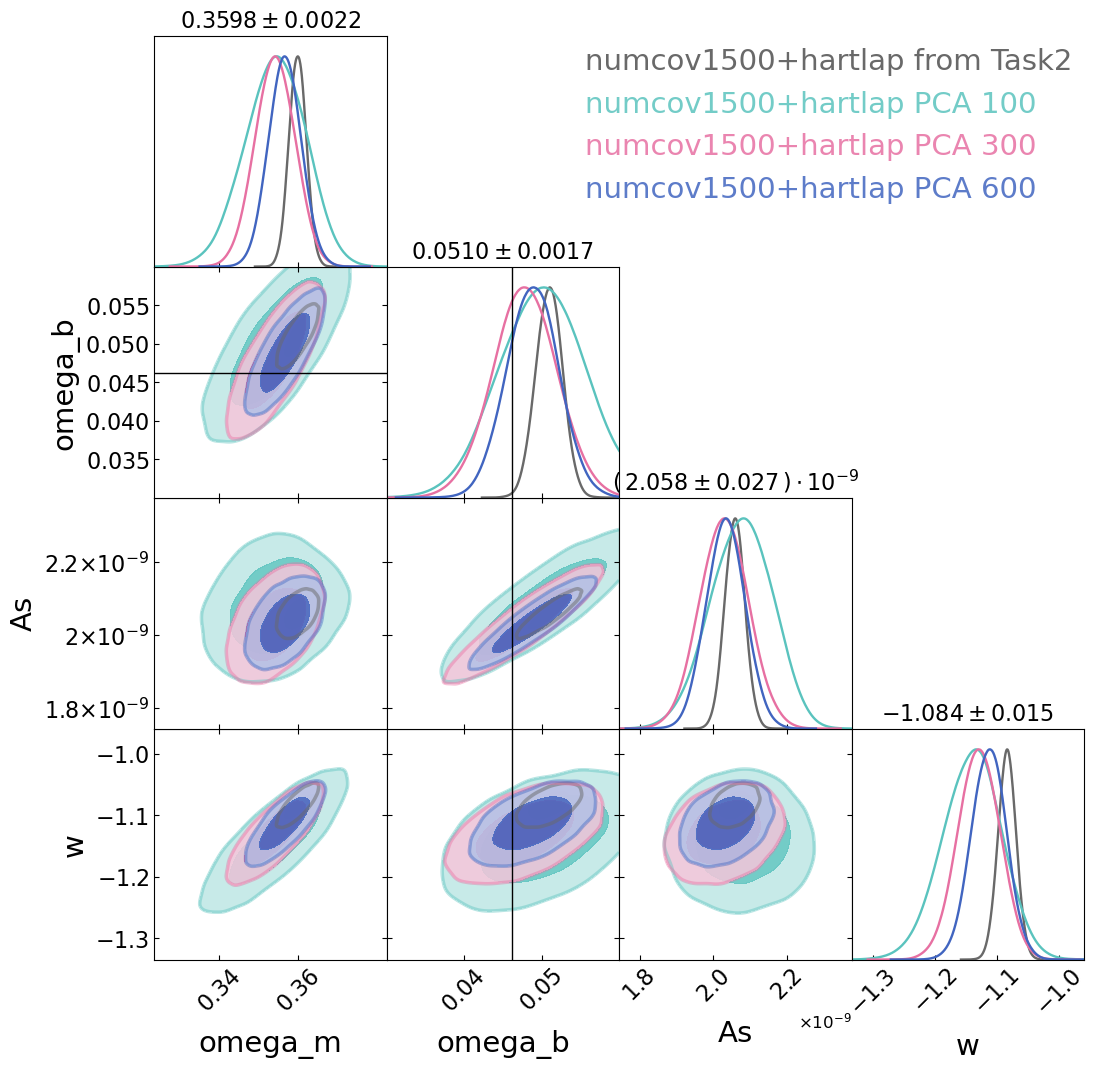

In [36]:
samples_emcee_hartlap = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_hartlap.npy')
samples_emcee_cov1500_pca100 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_pca100.npy')
samples_emcee_cov1500_pca300 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_pca300.npy')
samples_emcee_cov1500_pca600 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_pca600.npy')
chains = [samples_emcee_nohartlap, samples_emcee_cov1500_pca100, samples_emcee_cov1500_pca300, samples_emcee_cov1500_pca600]

plot_getdist_corner(chains, 'MCMC_corner_task3b_pca_extra', ['numcov1500+hartlap from Task2', 'numcov1500+hartlap PCA 100', 'numcov1500+hartlap PCA 300', 'numcov1500+hartlap PCA 600' ], True)

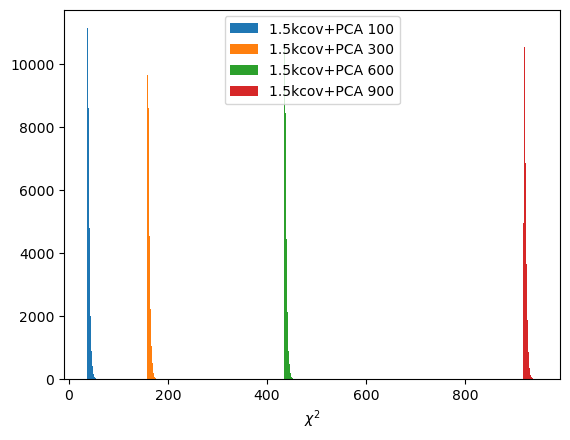

In [36]:
emcee_chi2_pca100 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_pca100.npy')
emcee_chi2_pca300 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_pca300.npy')
emcee_chi2_pca600 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_pca600.npy')
emcee_chi2_pca900 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_pca900.npy')


plot_chi2_distributions([emcee_chi2_pca100, emcee_chi2_pca300, emcee_chi2_pca600, emcee_chi2_pca900], 'chi2_distribution_task3b_pca', 
                        ['1.5kcov+PCA 100', '1.5kcov+PCA 300', '1.5kcov+PCA 600', '1.5kcov+PCA 900'])

##### Comments on Results:

To better understand the results, it made sense to create another corner plot comparing my result from task 2 with what was done here with task 3b. The key takeaway here is that, if we have a very noisy covaraince matrix, for example the 1.5k numerical covariance matrix, then PCA analysis is not effective. We saw previously in task 3, that when we use the analytical covariance matrix PCA analysis was able to obtain the same max constraining power quite fast with fewer degrees of freedom. What we find in this part of the task is that, we need more and more PCA elements, pretty much al 900, to obtain the same max parameter constraints. 

### 4. Run task 3 with the noise-free reference model. What difference do you observe in the MCMC chain and the corresponding $\chi^2$ distributions?

#### Noise-Free Reference Model - Analytical Cov Mat

In [37]:
## Function that computes the likelihood
def calc_likelihood_PCA_noisefree(para, cov_inv_pca, N_pca, pca):
    
    params = {'omega_b':reference_params['omega_b'],'w':reference_params['w'], 'omega_m':reference_params['omega_m'], 'As':reference_params['As']}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    pred_vector = cp_nn_model.predictions_np(params)[0]
    pred_vector_transformed = pca.transform([pred_vector*maximum+minimum])[0]
    
    reference_model_noisefree_transformed = pca.transform([reference_model])[0]
       
    # print(pred_vector.shape,reference_model.shape,cov_inv_pca.shape)
    
    delta = pred_vector_transformed - reference_model_noisefree_transformed
    
    
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv_pca,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior

In [38]:
for N_pca in [100,300,600,900]:#tqdm(np.arange(1,900)):
    
    pca = PCA(n_components=N_pca,svd_solver='full')
    models_pca = pca.fit(models-mean) # Perform the PCA fitting. Now you can use pca for the transformation
    
    # Rotating the covariance matrix
    rotation_matrix = pca.components_.T
    cov_pca = rotation_matrix.T @ cov @ rotation_matrix 
    
    inv_cov_pca = inv(cov_pca) # select the first N_pca elements

    
    sampler_pca_noisefree = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_PCA_noisefree, args=[inv_cov_pca, N_pca, pca])
    sampler_pca_noisefree.run_mcmc(p0, total_steps, progress=True)
    
    samples_emcee_pca_noisefree = sampler_pca_noisefree.get_chain(discard=burning_steps,flat=True)
    np.save('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca'+str(N_pca), samples_emcee_pca_noisefree)
    log_prob_samples_pca_noisefree = sampler_pca_noisefree.get_log_prob(discard=burning_steps, flat=True)
    np.save('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca'+str(N_pca), log_prob_samples_pca_noisefree)
    

100%|██████████| 3000/3000 [35:12<00:00,  1.42it/s]  


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


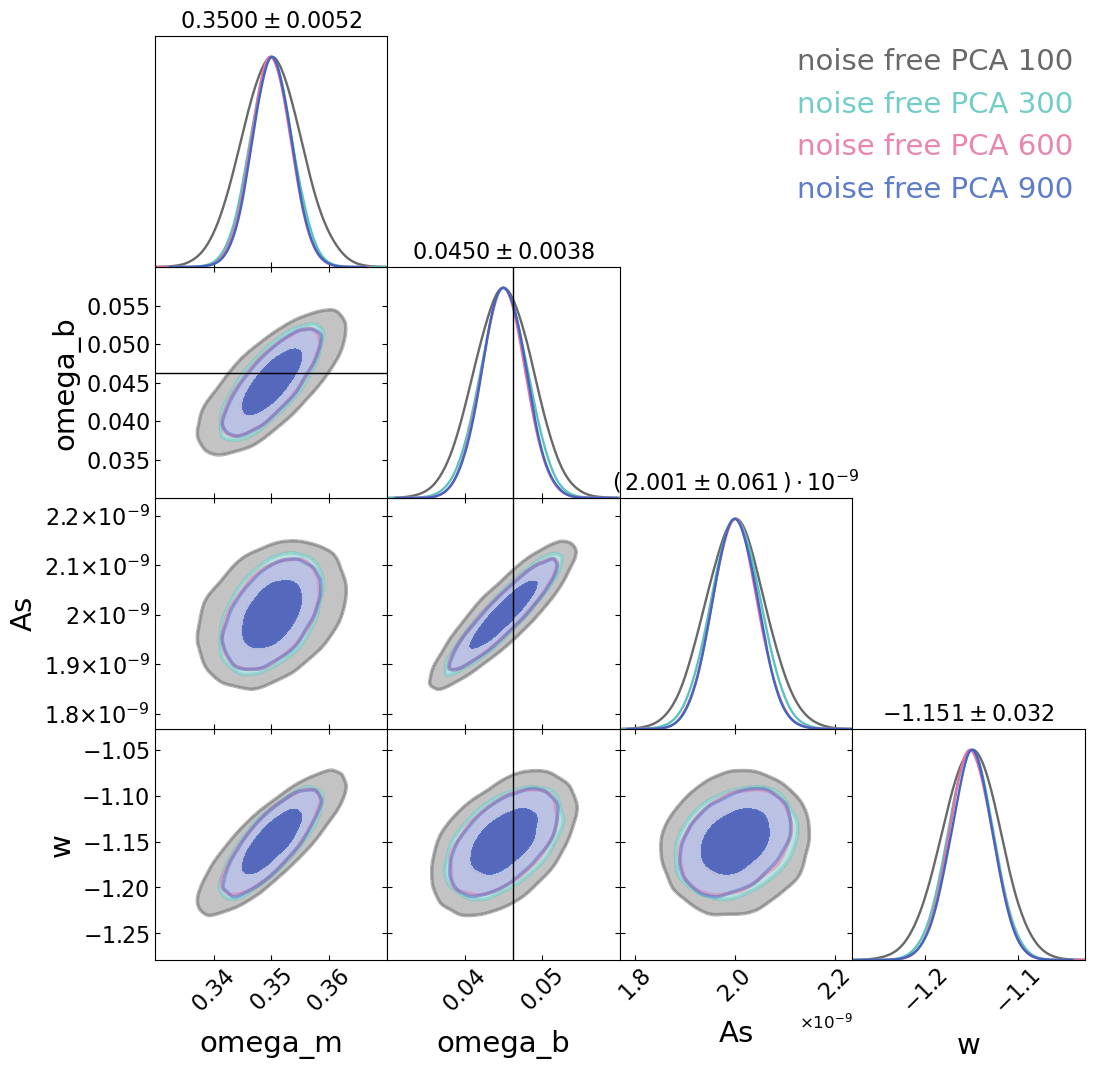

In [39]:
samples_emcee_noisefree_pca100 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca100.npy')
samples_emcee_noisefree_pca300 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca300.npy')
samples_emcee_noisefree_pca600 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca600.npy')
samples_emcee_noisefree_pca900 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca900.npy')
chains = [samples_emcee_noisefree_pca100, samples_emcee_noisefree_pca300, samples_emcee_noisefree_pca600, samples_emcee_noisefree_pca900]

plot_getdist_corner(chains, 'MCMC_corner_task4_pca_with_noisefree', ['noise free PCA 100','noise free PCA 300', 'noise free PCA 600', 'noise free PCA 900' ])

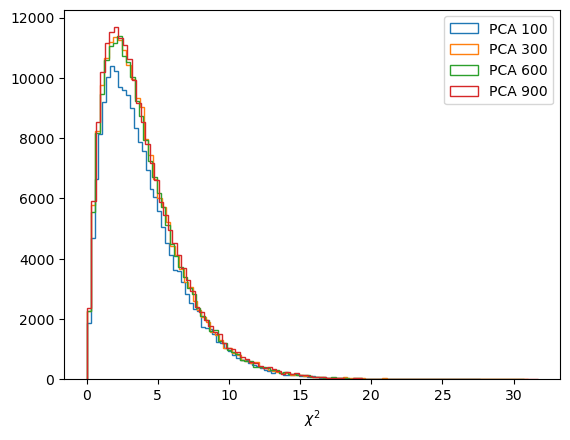

In [37]:
emcee_chi2_noisefree_pca100 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca100.npy')
emcee_chi2_noisefree_pca300 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca300.npy')
emcee_chi2_noisefree_pca600 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca600.npy')
emcee_chi2_noisefree_pca900 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca900.npy')


plot_chi2_distributions([emcee_chi2_noisefree_pca100, emcee_chi2_noisefree_pca300, emcee_chi2_noisefree_pca600, emcee_chi2_noisefree_pca900], 
                        'chi2_distribution_task4_analyticcov_pca', ['PCA 100', 'PCA 300', 'PCA 600', 'PCA 900'], True)

#### Noise-Free Reference Model - Numerical 1.5k Cov Mat 

In [20]:
## Function that computes the likelihood
def calc_likelihood_PCA_noisefree_hartlap(para, cov_inv_pca, N_pca, pca, realizations, dimensions):
    
    params = {'omega_b':reference_params['omega_b'],'w':reference_params['w'], 'omega_m':reference_params['omega_m'], 'As':reference_params['As']}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    pred_vector = cp_nn_model.predictions_np(params)[0]
    pred_vector_transformed = pca.transform([pred_vector*maximum+minimum])[0]
    
    reference_model_noisefree_transformed = pca.transform([reference_model])[0]
       
    # print(pred_vector.shape,reference_model.shape,cov_inv_pca.shape)
    
    delta = pred_vector_transformed - reference_model_noisefree_transformed
    
    n_r = realizations # number of realisations used  # this is the length of the numerical covariance matrix used or is it 900?
    n_d = dimensions # dimension of the model 
    h = (n_r-1)/(n_r-n_d-2)
    cov_inv_pca_hartlap = cov_inv_pca/h
    
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv_pca_hartlap,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior

In [42]:
for N_pca in [100,300,600,900]:#tqdm(np.arange(1,900)):
    
    pca = PCA(n_components=N_pca,svd_solver='full')
    models_pca = pca.fit(models-mean) # Perform the PCA fitting. Now you can use pca for the transformation
    
    # Rotating the covariance matrix
    rotation_matrix = pca.components_.T
    cov_pca = rotation_matrix.T @ cov_num_1500 @ rotation_matrix 
    
    inv_cov_pca = inv(cov_pca) # select the first N_pca elements

    sampler_pca_noisefree_numcov1500 = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_PCA_noisefree_hartlap, args=[inv_cov_pca, N_pca, pca, 1500, 900])
    sampler_pca_noisefree_numcov1500.run_mcmc(p0, total_steps, progress=True)
    
    samples_emcee_pca_noisefree_numcov1500 = sampler_pca_noisefree_numcov1500.get_chain(discard=burning_steps,flat=True)
    np.save('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca'+str(N_pca)+'_numcov1500', samples_emcee_pca_noisefree_numcov1500)
    log_prob_samples_pca_noisefree_numcov1500 = sampler_pca_noisefree_numcov1500.get_log_prob(discard=burning_steps, flat=True)
    np.save('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca'+str(N_pca)+'_numcov1500', log_prob_samples_pca_noisefree_numcov1500)
    

100%|██████████| 3000/3000 [43:05<00:00,  1.16it/s] 


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


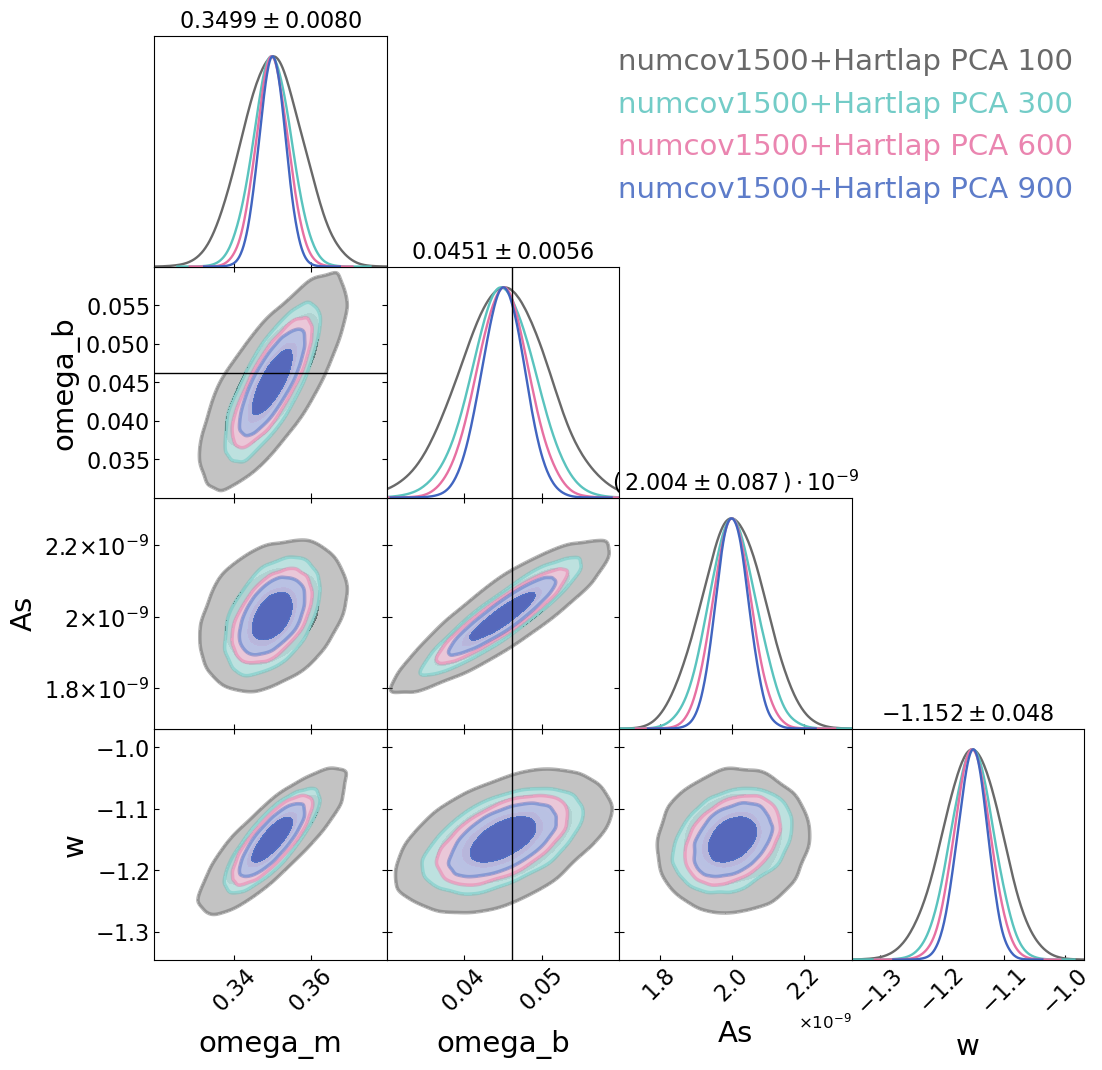

In [43]:
samples_emcee_cov1500_pca100 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca100_numcov1500.npy')
samples_emcee_cov1500_pca300 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca300_numcov1500.npy')
samples_emcee_cov1500_pca600 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca600_numcov1500.npy')
samples_emcee_cov1500_pca900 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca900_numcov1500.npy')

chains = [samples_emcee_cov1500_pca100, samples_emcee_cov1500_pca300, samples_emcee_cov1500_pca600, samples_emcee_cov1500_pca900]

plot_getdist_corner(chains, 'MCMC_corner_task4_pca_with_noisefree_numcov1500_Hartlap', 
                    ['numcov1500+Hartlap PCA 100','numcov1500+Hartlap PCA 300', 'numcov1500+Hartlap PCA 600', 'numcov1500+Hartlap PCA 900' ])

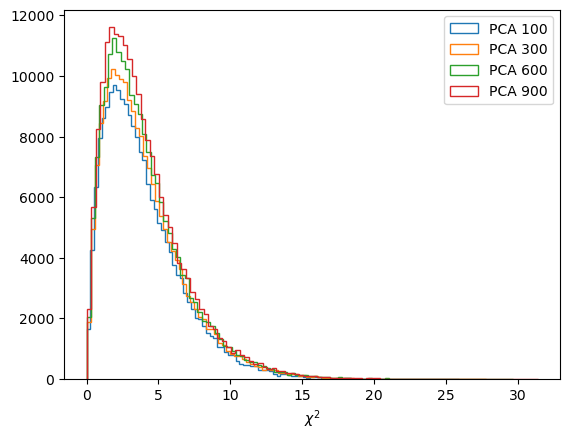

In [38]:
emcee_chi2_noisefree_1500cov_pca100 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca100_numcov1500.npy')
emcee_chi2_noisefree_1500cov_pca300 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca300_numcov1500.npy')
emcee_chi2_noisefree_1500cov_pca600 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca600_numcov1500.npy')
emcee_chi2_noisefree_1500cov_pca900 = -2*np.load('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca900_numcov1500.npy')


plot_chi2_distributions([emcee_chi2_noisefree_1500cov_pca100, emcee_chi2_noisefree_1500cov_pca300, emcee_chi2_noisefree_1500cov_pca600, emcee_chi2_noisefree_1500cov_pca900], 
                        'chi2_distribution_task4_1500cov_pca', ['PCA 100', 'PCA 300', 'PCA 600', 'PCA 900'], True)

#### Comments on Noise-Free Model:

<b style='color:red'> comments on the shift being due to the noise free and noisy model</b>

Once again, we see the same trends and conclusions as determined with task 3. We repeated task 3 using now the noise-free model+analytical covariance and then the noise-free model+1.5k num covariance. We see that when using a noise-free model in tandem with the analytical covaraince the PCA analysis is even more effective. Previously it took about 600 PCA elements to match the cmax onstraining power, but now, at only 300 PCA elemetns we already obtain the same constraining power. This is also shown in the chi2-distribtuon as the distribution for PCA 300 closely matches PCA 900 (all elements used).

In the second part, we reintroduce the very noisy 1.5k numerical covariance matrix. Based on the corner plot and chi2-distribution plots we make the same conclusion as before. Due to the noisiness of the num cov matrix, PCA analysis becomes ineffective. We see that even at PCA 600, the max constraining power is now reached. This is also shown in the chi2 distribution as the peak of PCA600 is still non-ngeligibly below PCA900.

#### 4.a Plot and compare the marginalised constraints on $\Omega_\mathrm{m}$ and $A_s$, as a function of the number of PCA elements. What do you observe?


In [20]:
p0 = start_position_lh_and_step_size(0)
N_pca_vals, Om_variances, Om_means,  As_means, As_variances = [], [], [], [], []


for N_pca in [2,5,10,25,50,75,100,150,200,300,600,900]:#tqdm(np.arange(1,900)):
    
    pca = PCA(n_components=N_pca,svd_solver='full')
    models_pca = pca.fit(models-mean) # Perform the PCA fitting. Now you can use pca for the transformation
    
    # Rotating the covariance matrix
    rotation_matrix = pca.components_.T
    cov_pca = rotation_matrix.T @ cov_num_1500 @ rotation_matrix 
    
    inv_cov_pca = inv(cov_pca) # select the first N_pca elements

    
    sampler_pca_noisefree_pca = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_PCA_noisefree_hartlap, args=[inv_cov_pca, N_pca, pca, 1500, 900])
    sampler_pca_noisefree_pca.run_mcmc(p0, total_steps, progress=True)
    samples_emcee_pca_noisefree = sampler_pca_noisefree_pca.get_chain(discard=burning_steps,flat=True)

    samples_getdist_noisefree_pca = MCSamples(samples=samples_emcee_pca_noisefree,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
    
    param_means = samples_getdist_noisefree_pca.getMeans()
    param_variances = samples_getdist_noisefree_pca.getVars()
    
    N_pca_vals.append(N_pca)
    Om_means.append(param_means[0])
    Om_variances.append(param_variances[0])
    As_means.append(param_means[2])
    As_variances.append(param_variances[2])
    
N_pca_vals = np.array(N_pca_vals)
Om_means = np.array(Om_means)
Om_std = np.array(np.sqrt(Om_variances))
As_means = np.array(As_means)
As_std = np.array(np.sqrt(As_variances))

100%|██████████| 3000/3000 [31:19<00:00,  1.60it/s]


Removed no burn in


100%|██████████| 3000/3000 [30:11<00:00,  1.66it/s] 


Removed no burn in


100%|██████████| 3000/3000 [21:40<00:00,  2.31it/s]


Removed no burn in


100%|██████████| 3000/3000 [21:55<00:00,  2.28it/s]


Removed no burn in


100%|██████████| 3000/3000 [33:18<00:00,  1.50it/s]  


Removed no burn in


100%|██████████| 3000/3000 [32:11<00:00,  1.55it/s] 


Removed no burn in


100%|██████████| 3000/3000 [32:38<00:00,  1.53it/s] 


Removed no burn in


100%|██████████| 3000/3000 [36:02<00:00,  1.39it/s] 


Removed no burn in


100%|██████████| 3000/3000 [37:42<00:00,  1.33it/s] 


Removed no burn in


100%|██████████| 3000/3000 [41:04<00:00,  1.22it/s] 


Removed no burn in


100%|██████████| 3000/3000 [57:57<00:00,  1.16s/it]  


Removed no burn in


100%|██████████| 3000/3000 [47:09<00:00,  1.06it/s] 

Removed no burn in


In [ ]:
np.save('data_4_assignment3/task4a_Om_means', Om_means)
np.save('data_4_assignment3/task4a_Om_std', Om_std)
np.save('data_4_assignment3/task4a_As_means', As_means)
np.save('data_4_assignment3/task4a_As_std', As_std)

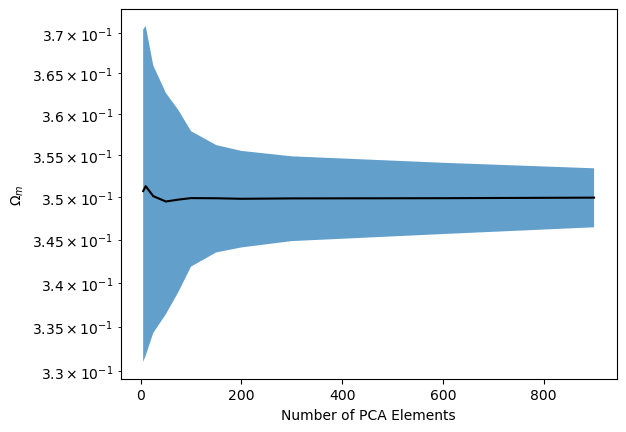

In [21]:
plt.plot(N_pca_vals[1:],Om_means[1:], color='black')
plt.fill_between(N_pca_vals[1:], Om_means[1:]-Om_std[1:],Om_means[1:]+Om_std[1:], alpha= 0.7)
plt.semilogy()

plt.xlabel('Number of PCA Elements')
plt.ylabel(r'$\Omega_{m}$')
plt.show()

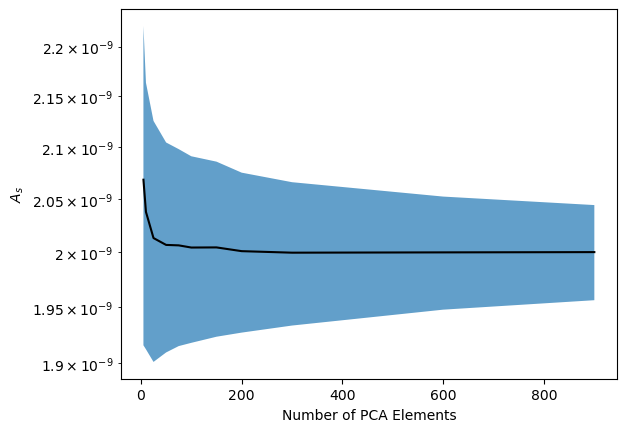

In [22]:
plt.plot(N_pca_vals[1:],As_means[1:], color='black')
plt.fill_between(N_pca_vals[1:], As_means[1:]-As_std[1:],As_means[1:]+As_std[1:], alpha= 0.7)
plt.semilogy()
plt.xlabel('Number of PCA Elements')
plt.ylabel(r'$A_{s}$')
#plt.ylim(1.99e-9, 2.025e-9)
plt.show()


##### Comments on 4a:

We see that as we take more and more PCA elements the marginalized constraints on $\Omega_{m}$ and $A_{s}$ get lower and lower. Since we are still using the noisy 1.5k num cov matrix, we see that the decreasing trend still continues all the way up to 900 PCA elements which would be the max constraints. In assignent 2, we saw that the marginalized constraints on parameters would converge faster to the max constraint and then plateau all the way to 900 PCA elements. 

#### 4.b To check if your answer in 4.a is robust, run multiple MCMC chains with the 1.5 covariance matrix and a fixed number of PCA elements. How big are the variations on the marginalised errors on $\Omega_\mathrm{m}$ and $A_s$? Is your answer in 4.a reliable? What can you improve to make 4.a reliable?

In [3]:
total_steps = 600 # total  number of steps each walker is doing
burning_steps = 300 # how many buring steps you want to remove
nwalkers = 100 # Number of walkers that probe the parameter space

In [27]:
models = np.load('data_4_assignment2/models.npy')
mean = np.mean(models,axis=0) # for numerical stability you should subtract the mean of each element

para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])
    
N_pca_vals_4b, Om_variances_repeated_npca, Om_means_repeated_npca,  As_means_repeated_npca, As_variances_repeated_npca = [], [], [], [], []
N_pca = 600

pca = PCA(n_components=N_pca,svd_solver='full')
models_pca = pca.fit(models-mean) # Perform the PCA fitting. Now you can use pca for the transformation

# Rotating the covariance matrix
rotation_matrix = pca.components_.T
cov_pca = rotation_matrix.T @ cov_num_1500 @ rotation_matrix  # using the 1.5k num cov

inv_cov_pca = inv(cov_pca) # select the first N_pca elements
    
for i in range(20):
    p0 = start_position_lh_and_step_size(i)
    # sampler_pca_noisefree_pca, samples_emcee_pca_noisefree
    
    a = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_PCA_noisefree_hartlap, args=[inv_cov_pca, N_pca, pca, 1500, 900])
    a.run_mcmc(p0, total_steps, progress=True)
    b = a.get_chain(discard=burning_steps,flat=True)

    samples_getdist_noisefree_pca = MCSamples(samples=b,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
    
    param_means = samples_getdist_noisefree_pca.getMeans()
    param_variances = samples_getdist_noisefree_pca.getVars()
    
    N_pca_vals_4b.append(N_pca)
    Om_means_repeated_npca.append(param_means[0])
    Om_variances_repeated_npca.append(param_variances[0])
    As_means_repeated_npca.append(param_means[2])
    As_variances_repeated_npca.append(param_variances[2])

N_pca_vals_4b = np.array(N_pca_vals_4b)
Om_means_repeated_npca = np.array(Om_means_repeated_npca)
Om_std_repeated_npca = np.array(np.sqrt(Om_variances_repeated_npca))
As_means_repeatedf_npca = np.array(As_means_repeated_npca)
As_std_repeated_npca = np.array(np.sqrt(As_variances_repeated_npca))

100%|██████████| 600/600 [11:49<00:00,  1.18s/it]


Removed no burn in


100%|██████████| 600/600 [11:58<00:00,  1.20s/it]


Removed no burn in


100%|██████████| 600/600 [16:08<00:00,  1.61s/it]


Removed no burn in


100%|██████████| 600/600 [16:20<00:00,  1.63s/it]


Removed no burn in


100%|██████████| 600/600 [09:30<00:00,  1.05it/s]


Removed no burn in


100%|██████████| 600/600 [14:40<00:00,  1.47s/it]


Removed no burn in


100%|██████████| 600/600 [12:28<00:00,  1.25s/it]


Removed no burn in


100%|██████████| 600/600 [14:07<00:00,  1.41s/it]


Removed no burn in


100%|██████████| 600/600 [10:19<00:00,  1.03s/it]


Removed no burn in


100%|██████████| 600/600 [12:23<00:00,  1.24s/it]


Removed no burn in


100%|██████████| 600/600 [12:27<00:00,  1.25s/it]


Removed no burn in


100%|██████████| 600/600 [12:35<00:00,  1.26s/it]


Removed no burn in


100%|██████████| 600/600 [12:45<00:00,  1.28s/it]


Removed no burn in


100%|██████████| 600/600 [12:36<00:00,  1.26s/it]


Removed no burn in


100%|██████████| 600/600 [12:21<00:00,  1.24s/it]


Removed no burn in


100%|██████████| 600/600 [12:19<00:00,  1.23s/it]


Removed no burn in


100%|██████████| 600/600 [12:26<00:00,  1.24s/it]


Removed no burn in


100%|██████████| 600/600 [12:26<00:00,  1.24s/it]


Removed no burn in


100%|██████████| 600/600 [12:29<00:00,  1.25s/it]


Removed no burn in


100%|██████████| 600/600 [12:29<00:00,  1.25s/it]

Removed no burn in


In [28]:
np.save('data_4_assignment3/task4b_Om_means_repeated_pca'+str(N_pca), Om_means_repeated_npca)
np.save('data_4_assignment3/task4b_Om_std_repeated_pca'+str(N_pca), Om_std_repeated_npca)
np.save('data_4_assignment3/task4b_As_means_repeated_pca'+str(N_pca), As_means_repeated_npca)
np.save('data_4_assignment3/task4b_As_std_repeated_pca'+str(N_pca), As_std_repeated_npca)

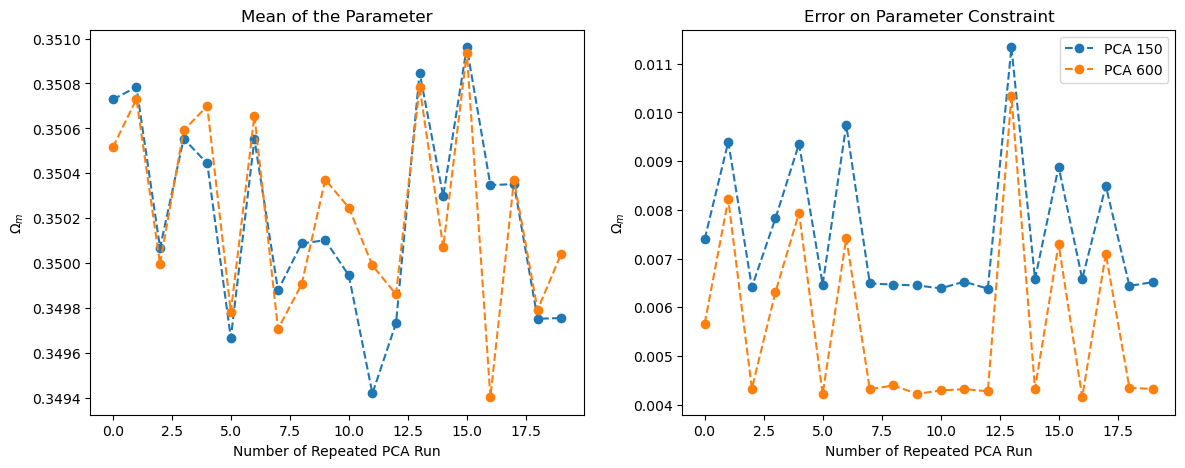

In [22]:
fig,axs = plt.subplots(1,2, figsize=(14,5))

npca_repeated = [150,600]

for npca in npca_repeated:
    mean_data = np.load('data_4_assignment3/task4b_Om_means_repeated_pca'+str(npca)+'.npy')
    std_data = np.load('data_4_assignment3/task4b_Om_std_repeated_pca'+str(npca)+'.npy')
    
    axs[0].plot(mean_data, '--o', label='PCA '+str(npca))
    axs[1].plot(std_data,  '--o', label='PCA '+str(npca))
    
   
for ax in axs:
    ax.set_xlabel('Number of Repeated PCA Run')
    ax.set_ylabel(r'$\Omega_{m}$')


axs[0].set_title('Mean of the Parameter')
axs[1].set_title('Error on Parameter Constraint')

plt.legend(loc='best')  

plt.savefig('plots_4_assignment3/task4b_Om.jpg',dpi=400, bbox_inches='tight')

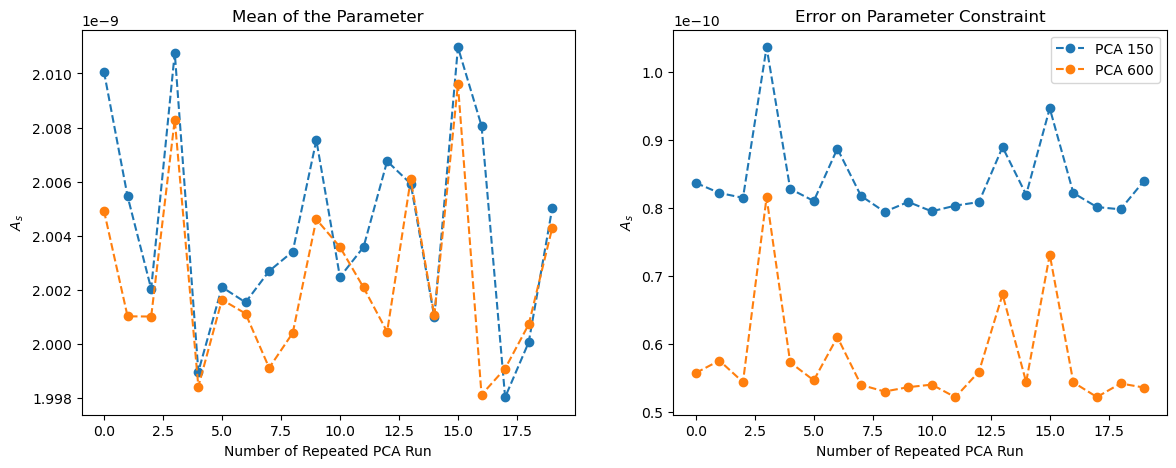

In [24]:
fig,axs = plt.subplots(1,2, figsize=(14,5))

npca_repeated = [150,600]

for npca in npca_repeated:
    mean_data = np.load('data_4_assignment3/task4b_As_means_repeated_pca'+str(npca)+'.npy')
    std_data = np.load('data_4_assignment3/task4b_As_std_repeated_pca'+str(npca)+'.npy')
    
    axs[0].plot(mean_data, '--o', label='PCA '+str(npca))
    axs[1].plot(std_data,  '--o', label='PCA '+str(npca))
    
   
for ax in axs:
    ax.set_xlabel('Number of Repeated PCA Run')
    ax.set_ylabel(r'$A_{s}$')


axs[0].set_title('Mean of the Parameter')
axs[1].set_title('Error on Parameter Constraint')

plt.legend(loc='best')  

plt.savefig('plots_4_assignment3/task4b_As.jpg',dpi=400, bbox_inches='tight')

In [26]:
Om_mean_data_150 = np.load('data_4_assignment3/task4b_Om_means_repeated_pca'+str(150)+'.npy')
Om_std_data_150 = np.load('data_4_assignment3/task4b_Om_std_repeated_pca'+str(150)+'.npy')
Om_mean_data_600 = np.load('data_4_assignment3/task4b_Om_means_repeated_pca'+str(600)+'.npy')
Om_std_data_600 = np.load('data_4_assignment3/task4b_Om_std_repeated_pca'+str(600)+'.npy')


As_mean_data_150 = np.load('data_4_assignment3/task4b_As_means_repeated_pca'+str(150)+'.npy')
As_std_data_150 = np.load('data_4_assignment3/task4b_As_std_repeated_pca'+str(150)+'.npy')
As_mean_data_600 = np.load('data_4_assignment3/task4b_As_means_repeated_pca'+str(600)+'.npy')
As_std_data_600 = np.load('data_4_assignment3/task4b_As_std_repeated_pca'+str(600)+'.npy')

In [34]:
# The max error in the marginalized contraint over 20 repeated runs:
print(r'The max error for $\Omega_{m}$ using PCA150: ', np.max(Om_std_data_150))
print(r'The max error for $\Omega_{m}$ using PCA600: ', np.max(Om_std_data_600))
print('----------------------------------------')
print(r'The max error for $A_{s}$ using PCA150: ', np.max(As_std_data_150))
print(r'The max error for $A_{s}$ using PCA600: ', np.max(As_std_data_600))

# The min error in the marginalized constraint over 20 repeated runs: 
print(r'The min error for $\Omega_{m}$ using PCA150: ', np.min(Om_std_data_150))
print(r'The min error for $\Omega_{m}$ using PCA600: ', np.min(Om_std_data_600))
print('----------------------------------------')
print(r'The min error for $A_{s}$ using PCA150: ', np.min(As_std_data_150))
print(r'The min error for $A_{s}$ using PCA600: ', np.min(As_std_data_600))

# Taking the parameter constraints and uncertainties from task 1 for omega_m and A_s and seeing what percent of that it is for the repeated runs
print('----------------------------------------')
print('The variation in the error for Omega_m for PCA 150 is: ', (np.min(Om_std_data_150)/0.0034)*100,'-', (np.max(Om_std_data_150)/0.0034)*100 , '% of the parameter uncerntainty found in task 1' )
print('The variation in the error for Omega_m for PCA 600 is: ', (np.min(Om_std_data_600)/0.0034)*100,'-', (np.max(Om_std_data_600)/0.0034)*100 , '% of the parameter uncerntainty found in task 1' )
print('----------------------------------------')
print('The variation in the error for A_s for PCA 150 is: ', (np.min(As_std_data_150)/0.045e-9)*100,'-', (np.max(As_std_data_150)/0.045e-9)*100 , '% of the parameter uncerntainty found in task 1' )
print('The variation in the error for A_s for PCA 600 is: ', (np.min(As_std_data_600)/0.045e-9)*100,'-', (np.max(As_std_data_600)/0.045e-9)*100 , '% of the parameter uncerntainty found in task 1' )


The max error for $\Omega_{m}$ using PCA150:  0.01133813393313082
The max error for $\Omega_{m}$ using PCA600:  0.01033459114923052
----------------------------------------
The max error for $A_{s}$ using PCA150:  1.0369050891249738e-10
The max error for $A_{s}$ using PCA600:  8.156681601529371e-11
The min error for $\Omega_{m}$ using PCA150:  0.0063835834202380275
The min error for $\Omega_{m}$ using PCA600:  0.004156233695391557
----------------------------------------
The min error for $A_{s}$ using PCA150:  7.943268134365213e-11
The min error for $A_{s}$ using PCA600:  5.21116529990498e-11
----------------------------------------
The variation in the error for Omega_m for PCA 150 is:  187.7524535364126 - 333.4745274450241 % of the parameter uncerntainty found in task 1
The variation in the error for Omega_m for PCA 600 is:  122.2421675115164 - 303.95856321266234 % of the parameter uncerntainty found in task 1
----------------------------------------
The variation in the error for A

##### Comments on 4b:


Is my result in 4a reliable, yes and no, does it make sense, yes. What we see from the results for 4b is that if we performed repeated MCMC runs at the same PCA number the variations in the errors of the parameters depeneds on how many PCA elements you're using. For this, I present results in my plots for repeated runs using 150 and 600 PCA elements. We see that the more PCA elements we use, the magnitude of the errors and how much they change from one run to the other decreases. This trend is in agreement with what we see in 4a where, as we use more and more PCA elements the overall marginalized constraints get better and better till it plateaus (well, more like levels out). To further prove this trend, in the cell above I calcualted the percentage/fraction that the largest and smallest errors were as compared to the errors determined back in task 1 for omega_m and A_s.

Using only 150 PCA elements, the errors ranged from 188% to 333% and 177% to 230% for Omega_m and A_s respectively. Using 600 PCA elements, this range decresed to 122% to 304%  and 116% to 181% for Omega_m and A_s respectively. 


How do we improve this?
- Don't use the very noisy 1.5k numerical covaraince matrix. If we had to use a num cov matrix, using one with more data vectors would improve these results and lead to smaller fluctuations in the marginalized constraints. 
- We could also improve the errors and constraints on parameters but actaully taking the mean of many repeated runs, as the error should decrese appropriately. 

### 5. Bonus: Use an MCMC sampler not described in the attached notebook. Compare its performance (speed, accuracy) to the samplers we provided.
###